In [3]:
import cv2
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, Dense, Dropout, BatchNormalization, SimpleRNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.stats import f
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
def extract_features_list(image_path, model):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = tf.expand_dims(image, axis=0)
    features_list = model(image)
    return features_list.numpy()

def CNN_model(frame_directory):
    model_url = 'mobilenet-v2-tensorflow2-tf2-preview-feature-vector-v4'
    model = hub.load(model_url)
    frame_files = os.listdir(frame_directory)
    video_features = []
    frame_count = 0 

    if frame_directory == 'Frames_Modified':
        for i in range(len(frame_files)):   
            frame_path = f'{frame_directory}/frame_{i:04d}.jpg'
            features_list = extract_features_list(frame_path, model)
            if np.any(np.isnan(features_list)) or np.any(np.isinf(features_list)):
                continue
            video_features.append(features_list)
            frame_count += 1
        video_features = np.vstack(video_features)
    else:
        for i in range(len(frame_files)):   
            frame_path = f'{frame_directory}/frame_{i:05d}.jpg'
            features_list = extract_features_list(frame_path, model)
            if np.any(np.isnan(features_list)) or np.any(np.isinf(features_list)):
                continue
            video_features.append(features_list)
            frame_count += 1
        video_features = np.vstack(video_features)

    return video_features, frame_count

def hotelling_t2(point, mean, cov, n, num_components):
    point = point - mean
    inv_cov = np.linalg.inv(cov)
    t2 = n * np.dot(np.dot(point, inv_cov), point)
    return t2

def dim_reduction(features, frame_count, num_principal_components=6):
    pca = PCA(n_components=num_principal_components)
    reduced_features = pca.fit_transform(features)
    mean_reduced_features = np.mean(reduced_features, axis=0)
    cov_reduced_features = np.cov(reduced_features, rowvar=False)
    t2_stats = []
    for i in range(len(reduced_features)):
        t2 = hotelling_t2(reduced_features[i], mean_reduced_features, cov_reduced_features, frame_count, num_principal_components)
        t2_stats.append(t2)
    
    return t2_stats, reduced_features

def train_test_splitting(features, t2_values):
    X_train, X_test, y_train, y_test = train_test_split(features, t2_values, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test


def train_test_data(optimal, regular, t2_optimal, t2_regular):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(optimal)
    X_test_scaled = scaler.transform(regular)
    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(np.array(t2_optimal).reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(np.array(t2_regular).reshape(-1, 1)).flatten()

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

def create_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length])
    return np.array(sequences), np.array(sequence_labels)


def input_RNN(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, seq_length=15):
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_length)
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, X_train_seq.shape[2]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], seq_length, X_test_seq.shape[2]))

    return X_train_seq, y_train_seq, X_test_seq, y_test_seq


def RNN_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq, seq_length=15):
    model = Sequential()
    model.add(SimpleRNN(128, activation='relu', input_shape=(seq_length, X_train_seq.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(SimpleRNN(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train_seq, y_train_seq, epochs=400, batch_size=64, validation_data=(X_test_seq, y_test_seq), verbose=0)

    return model

def prediction(model, test_data):
    return model.predict(test_data)

def rolling_mean_std(data, window_size):
    means = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    stds = np.array([np.std(data[i:i+window_size]) for i in range(len(data) - window_size + 1)])
    return means, stds


def rolling_window_threshold(predicted, true, window_size = 50):
    data = true.flatten()
    rolling_mean, rolling_std = rolling_mean_std(data, window_size)
    rolling_threshold = rolling_mean + 2 * rolling_std
    extended_rolling_std = np.pad(rolling_std, (0, len(data) - len(rolling_std)), 'constant', constant_values=np.nan)
    rolling_threshold = np.pad(rolling_threshold, (0, len(data) - len(rolling_threshold)), 'constant', constant_values=np.nan)

    true_anomalies_rolling = np.abs(data - np.nanmean(rolling_mean)) > rolling_threshold
    pred_anomalies_rolling = np.abs(predicted.flatten() - np.nanmean(rolling_mean)) > rolling_threshold

    true_anomalies_binary_rolling = true_anomalies_rolling.astype(int)
    pred_anomalies_binary_rolling = pred_anomalies_rolling.astype(int)

    accuracy_rolling = accuracy_score(true_anomalies_binary_rolling, pred_anomalies_binary_rolling)
    precision_rolling = precision_score(true_anomalies_binary_rolling, pred_anomalies_binary_rolling)
    recall_rolling = recall_score(true_anomalies_binary_rolling, pred_anomalies_binary_rolling)
    f1_rolling = f1_score(true_anomalies_binary_rolling, pred_anomalies_binary_rolling)

    print(f"Accuracy: {accuracy_rolling}")
    print(f"Precision: {precision_rolling}")
    print(f"Recall  {recall_rolling}")
    print(f"F1 Score: {f1_rolling}")

    plt.figure(figsize=(16, 8))
    plt.rcParams.update({'font.size': 14}) 
    plt.plot(true, color='blue', label='True Values')
    plt.plot(predicted.flatten(), color='orange', label='Predicted Values')
    plt.plot(np.concatenate([np.full(window_size-1, np.nan), rolling_threshold]), color='red', label='Rolling Threshold')
    plt.title('Anomaly Detection with Rolling Threshold', fontsize=18)
    plt.xlabel('Frame', fontsize=16)   
    plt.ylabel('Value',fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # df = pd.DataFrame({
    #     "Frame": np.arange(len(data)),
    #     "True Values": data,
    #     "Predicted Values": predicted.flatten(),
    #     "Rolling Threshold": rolling_threshold,
    #     "True Anomalies (Binary)": true_anomalies_binary_rolling,
    #     "Predicted Anomalies (Binary)": pred_anomalies_binary_rolling
    # })

    # # Save to CSV
    # df.to_csv('output.csv', index=False)
    # print(f"Anomaly detection results saved to output_csv")

    return accuracy_rolling, precision_rolling, recall_rolling, f1_rolling, true_anomalies_binary_rolling, pred_anomalies_binary_rolling
   
# def optimal_time_range(true, predicted, test_predictions, start_voltage, end_voltage, window_size=150, step_size=1):
#     true_anomalies_counts = []
#     pred_anomalies_counts = []
#     pred_values_sums = []
#     for start in range(start_voltage, end_voltage, step_size):
#         end = start + window_size
#         true_count = np.sum(true[start:end])
#         true_anomalies_counts.append(true_count)
#         pred_count = np.sum(predicted[start:end])
#         pred_anomalies_counts.append(pred_count)
#         pred_sum = np.sum(np.abs(test_predictions.flatten()[start:end]))
#         pred_values_sums.append(pred_sum)

#     true_anomalies_counts = np.array(true_anomalies_counts)
#     pred_anomalies_counts = np.array(pred_anomalies_counts)
#     pred_values_sums = np.array(pred_values_sums)

#     pred_anomalies_norm = pred_anomalies_counts / np.max(pred_anomalies_counts)
#     pred_values_norm = pred_values_sums / np.max(pred_values_sums)  

#     combined_score = pred_anomalies_norm + pred_values_norm

#     optimal_window_idx = np.argmin(combined_score)

#     optimal_range_start = optimal_window_idx * step_size
#     optimal_range_end = optimal_range_start + window_size

#     # Print the results
#     print(f"Optimal range with the least anomalies and low test predictions: {optimal_range_start} to {optimal_range_end}")
#     print(f"True anomalies count in this range: {true_anomalies_counts[optimal_window_idx]}")
#     print(f"Predicted anomalies count in this range: {pred_anomalies_counts[optimal_window_idx]}")
#     print(f"Prediction value sum in this range: {pred_values_sums[optimal_window_idx]}")

#     return optimal_range_start, optimal_range_end


def optimal_time_range(true, predicted, test_predictions, start_voltage, end_voltage, window_size=150, step_size=1, overlap_span=150, top_n=5):
    true_anomalies_counts_start = []
    pred_anomalies_counts_start = []
    pred_values_sums_start = []
    
    true_anomalies_counts_end = []
    pred_anomalies_counts_end = []
    pred_values_sums_end = []
    
    # Moving from start to end
    for start in range(start_voltage, end_voltage - window_size + 1, step_size):
        end = start + window_size
        true_count = np.sum(true[start:end])
        true_anomalies_counts_start.append(true_count)
        pred_count = np.sum(predicted[start:end])
        pred_anomalies_counts_start.append(pred_count)
        pred_sum = np.sum(np.abs(test_predictions.flatten()[start:end]))
        pred_values_sums_start.append(pred_sum)

    # Moving from end to start
    for start in range(end_voltage - window_size, start_voltage - 1, -step_size):
        end = start + window_size
        true_count = np.sum(true[start:end])
        true_anomalies_counts_end.append(true_count)
        pred_count = np.sum(predicted[start:end])
        pred_anomalies_counts_end.append(pred_count)
        pred_sum = np.sum(np.abs(test_predictions.flatten()[start:end]))
        pred_values_sums_end.append(pred_sum)

    # Normalize counts and values
    true_anomalies_counts_start = np.array(true_anomalies_counts_start)
    pred_anomalies_counts_start = np.array(pred_anomalies_counts_start)
    pred_values_sums_start = np.array(pred_values_sums_start)

    true_anomalies_counts_end = np.array(true_anomalies_counts_end)
    pred_anomalies_counts_end = np.array(pred_anomalies_counts_end)
    pred_values_sums_end = np.array(pred_values_sums_end)

    # Normalization with safety checks
    pred_anomalies_norm_start = pred_anomalies_counts_start / np.max(pred_anomalies_counts_start) if np.max(pred_anomalies_counts_start) != 0 else pred_anomalies_counts_start
    pred_values_norm_start = pred_values_sums_start / np.max(pred_values_sums_start) if np.max(pred_values_sums_start) != 0 else pred_values_sums_start
    
    pred_anomalies_norm_end = pred_anomalies_counts_end / np.max(pred_anomalies_counts_end) if np.max(pred_anomalies_counts_end) != 0 else pred_anomalies_counts_end
    pred_values_norm_end = pred_values_sums_end / np.max(pred_values_sums_end) if np.max(pred_values_sums_end) != 0 else pred_values_sums_end

    combined_score_start = pred_anomalies_norm_start + pred_values_norm_start
    combined_score_end = pred_anomalies_norm_end + pred_values_norm_end

    # Track all valid overlaps
    valid_overlaps = []

    for i in range(len(combined_score_start)):
        for j in range(len(combined_score_end)):
            start_idx_start = start_voltage + (i * step_size)
            end_idx_start = start_idx_start + window_size
            
            start_idx_end = end_voltage - window_size - (j * step_size)
            end_idx_end = start_idx_end + window_size
            
            # Precise overlap calculation
            overlap_start = max(start_idx_start, start_idx_end)
            overlap_end = min(end_idx_start, end_idx_end)
            
            # Strict overlap span check
            if (overlap_end - overlap_start <= overlap_span and 
                overlap_start >= start_voltage and 
                overlap_end <= end_voltage):
                
                # Calculate the combined score for this overlap
                overlap_score_start = combined_score_start[i]
                overlap_score_end = combined_score_end[j]
                combined_overlap_score = overlap_score_start + overlap_score_end

                valid_overlaps.append({
                    'start': overlap_start,
                    'end': overlap_end,
                    'score': combined_overlap_score
                })

    # Sort overlaps by score in ascending order
    sorted_overlaps = sorted(valid_overlaps, key=lambda x: x['score'])

    # Return top N optimal ranges (or all if fewer than N)
    top_ranges = sorted_overlaps[:top_n]

    if top_ranges:
        print("Top Optimal Ranges (Ascending Order):")
        for idx, overlap in enumerate(top_ranges, 1):
            print(f"{idx}. Range: {overlap['start']} to {overlap['end']}, Score: {overlap['score']:.4f}")
        
        return top_ranges
    else:
        print("No overlap within the desired range.")
        return []
    
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_and_save_range_frames(data, start_second, end_second, fps, output_csv="output_range.csv"):
    flattened_predictions = np.array([pred[0] for pred in data])
    # Convert seconds to frame indices
    start_frame = int(start_second * fps)
    end_frame = int(end_second * fps)

    # Extract the range of data
    data_range = flattened_predictions[start_frame:end_frame]

    # Generate time values based on frame indices
    time_values = np.linspace(start_second, end_second, len(data_range))

    # Create a DataFrame for the range
    df = pd.DataFrame({
        "Time (seconds)": time_values,
        "Value": data_range
    })

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Data saved to {output_csv}")

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_values, data_range, label="Data Range", marker='o')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value")
    plt.title(f"Data Plot from {start_second}s to {end_second}s")
    plt.legend()
    plt.grid(True)
    plt.show()


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_and_save_all_frames(data, fps, output_csv="output_full_range.csv"):
    # Flatten predictions if stored as lists of lists
    flattened_predictions = np.array([pred[0] for pred in data])

    # Generate time values based on frame indices
    total_frames = len(flattened_predictions)
    time_values = np.arange(0, total_frames / fps, 1 / fps)[:total_frames]

    # Create a DataFrame for all frames
    df = pd.DataFrame({
        "Time (seconds)": time_values,
        "Value": flattened_predictions
    })

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Entire dataset saved to {output_csv}")

    # Plot the entire dataset
    plt.figure(figsize=(12, 6))
    plt.plot(time_values, flattened_predictions, label="Entire Data Range", marker='o', markersize=2)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Value")
    plt.title("Full Data Plot")
    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
optimal_frame_dir = 'frames_optimal'
fps = 30
def bootstrapping_function(args):
    frame_dir, start_voltage, end_voltage = args
    optimal_features, frame_count1 = CNN_model(optimal_frame_dir)
    normal_features, frame_count2 = CNN_model(frame_dir)
    t2_optimal, optimal_reduced = dim_reduction(optimal_features, frame_count1)
    t2_normal, normal_reduced = dim_reduction(normal_features, frame_count2)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_data(optimal_reduced, normal_reduced, t2_optimal, t2_normal)
    X_train_seq, y_train_seq, X_test_seq, y_test_seq = input_RNN(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
    RNNmodel = RNN_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    predictions = prediction(RNNmodel, X_test_seq)
    a, p, r, f, true_anomalies, predicted_anomalies = rolling_window_threshold(predictions, y_test_seq)
    optimal_time_range(true_anomalies, predicted_anomalies, predictions, start_voltage * fps, end_voltage * fps)
    return predictions

# main_function(frame_dir, optimal_frame_dir, start_voltage, end_voltage)

In [7]:
def regular_function(args):
    frame_dir, start_voltage, end_voltage = args
    normal_features, frame_count2 = CNN_model(frame_dir)
    t2_normal, normal_reduced = dim_reduction(normal_features, frame_count2)
    X_train, X_test, y_train, y_test = train_test_splitting(normal_reduced, t2_normal)
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_data(X_train, X_test, y_train, y_test)
    X_train_seq, y_train_seq, X_test_seq, y_test_seq = input_RNN(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
    RNNmodel = RNN_model(X_train_seq, y_train_seq, X_test_seq, y_test_seq)
    predictions = prediction(RNNmodel, X_test_seq)
    a, p, r, f, true_anomalies, predicted_anomalies = rolling_window_threshold(predictions, y_test_seq)
    

In [8]:
arg_list = [
        # ['frames_0.1wt/0.1KVAC', 4, 150],
        # ['frames_0.1wt/0.1KVDC', 4, 159],
        # ['frames_0.1wt/0.3KVAC', 4, 159],
        # ['frames_0.1wt/0.3KVDC', 4, 153],
        # ['frames_0.1wt/0.5KVAC', 4, 153],
        # ['frames_0.1wt/0.5KVDC', 60, 180],
        # ['frames_0.1wt/0.7KVAC', 4, 153],
        # ['frames_0.1wt/0.7KVDC', 60, 180],
        # ['frames_0.1wt/0.9KVAC', 60, 180],
        # ['frames_0.1wt/0.9KVDC', 60, 180],
        # ['frames_0.1wt/1.1KVAC', 30, 60],
        # ['frames_0.1wt/1.3KVAC', 30, 60],
        # ['frames_AV1kV', 45, 75],
        # ['frames_Ac2kV', 25, 130],
        # ['frames_3kVAC', 25, 130],
        # ['frames_0.2KVDC', 2, 40],
        # ['frames_0.6KVDC', 2, 40],
        # ['frames_1KVDC', 2, 40],
        # ['Frames_Modified', 2, 40]
        ['LC+SIC_frames/1.5kVAC', 2, 111],
        ['LC+SIC_frames/2.5kVAC', 2, 121],
        ['LC+SIC_frames/3.5kVAC', 2, 132],
        ['LC+SIC_frames/4.5kVAC', 2, 112],
        ['LC+SIC_frames/2.7kVAC', 2, 114],
        ['LC+SIC_frames/2.9kVAC', 2, 129],
        ['LC+SIC_frames/3.1kVAC', 2, 139],
        ['LC+SIC_frames/3.3kVAC', 2, 153],
        ['LC+SIC_frames/0.1kVDC', 2, 99],
        ['LC+SIC_frames/0.3kVDC', 2, 147],
        ['LC+SIC_frames/0.5kVDC', 2, 185],
        ['LC+SIC_frames/0.7kVDC', 2, 122],
        ['LC+SIC_frames/0.9kVDC', 2, 130]

        ]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9084332762231107
Precision: 0.9206664022213408
Recall  0.982849883548592
F1 Score: 0.950742447516641


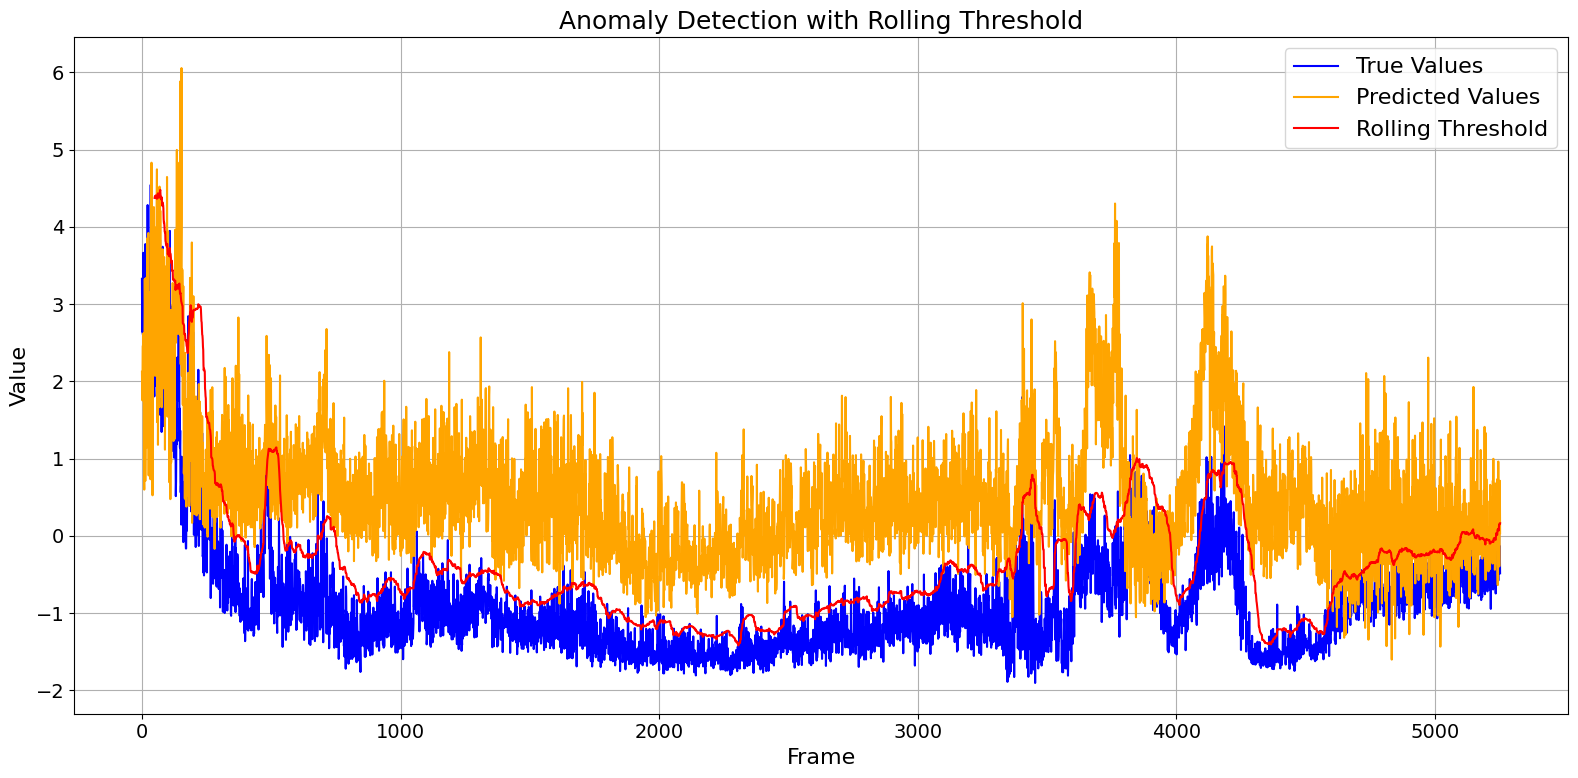

Top Optimal Ranges (Ascending Order):
1. Range: 2329 to 2479, Score: 2.2392
2. Range: 2329 to 2478, Score: 2.2407
3. Range: 2329 to 2478, Score: 2.2407
4. Range: 2330 to 2479, Score: 2.2415
5. Range: 2330 to 2479, Score: 2.2415


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8918510115333711
Precision: 0.9011904761904762
Recall  0.9839688041594454
F1 Score: 0.9407622203811102


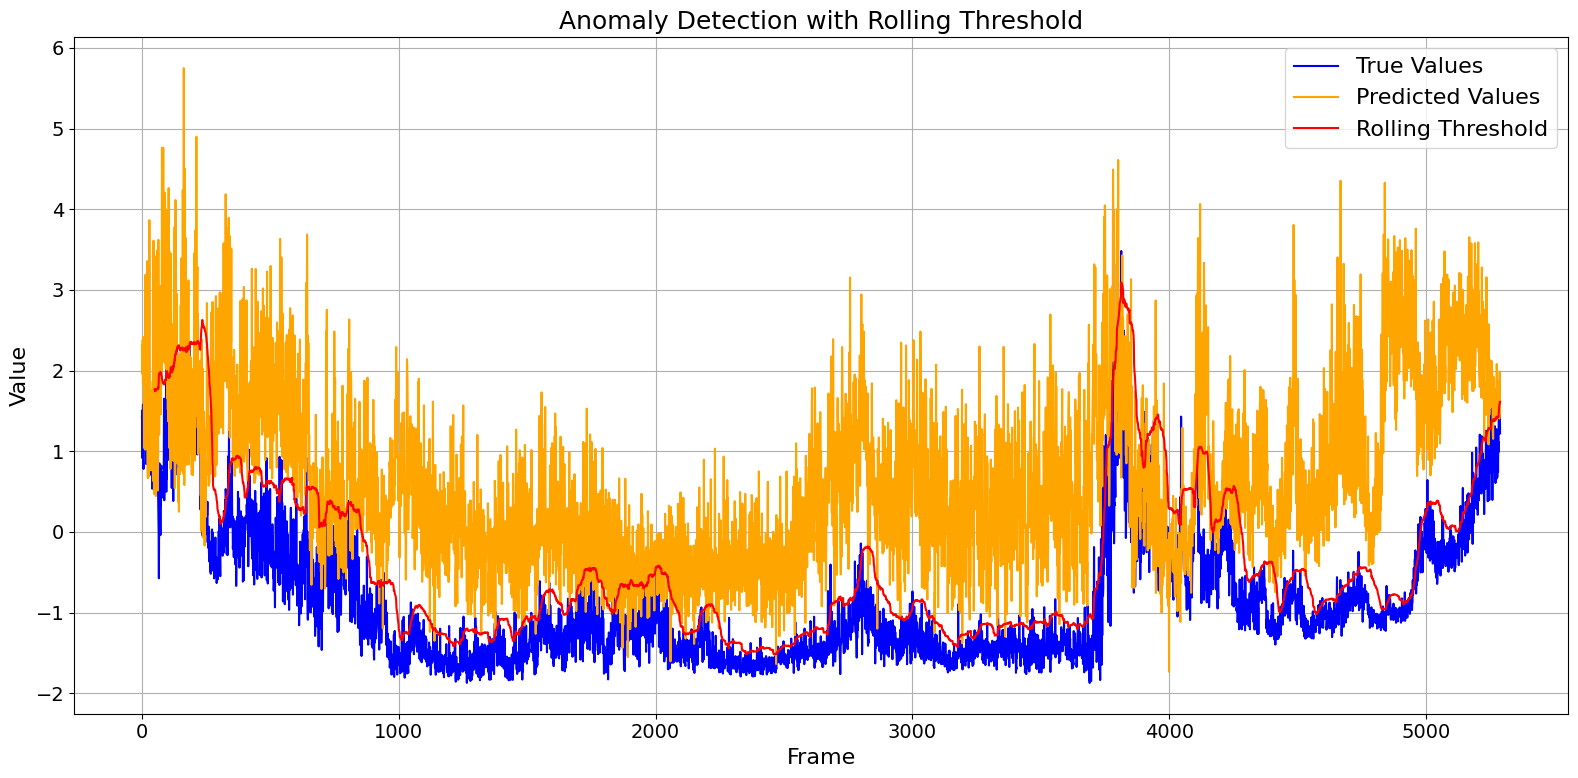

Top Optimal Ranges (Ascending Order):
1. Range: 1143 to 1293, Score: 2.3597
2. Range: 1143 to 1292, Score: 2.3603
3. Range: 1143 to 1292, Score: 2.3603
4. Range: 1143 to 1274, Score: 2.3605
5. Range: 1143 to 1274, Score: 2.3605


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8630633742013469
Precision: 0.8810289389067524
Recall  0.9659892160929076
F1 Score: 0.9215550499554852


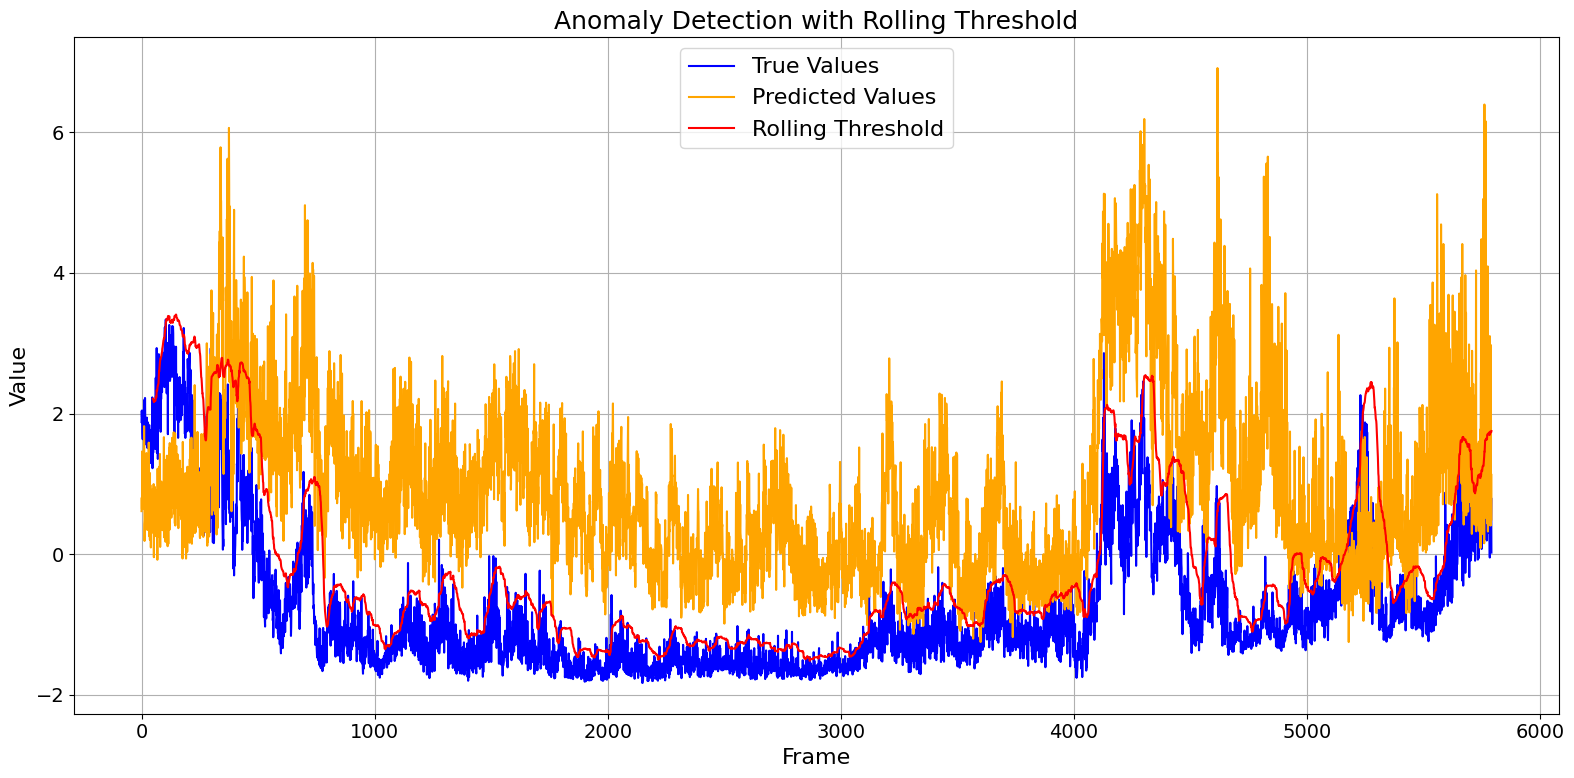

Top Optimal Ranges (Ascending Order):
1. Range: 64 to 214, Score: 0.5548
2. Range: 64 to 210, Score: 0.5561
3. Range: 64 to 210, Score: 0.5561
4. Range: 64 to 213, Score: 0.5561
5. Range: 64 to 213, Score: 0.5561


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9212876814291031
Precision: 0.9341850561362757
Recall  0.9830922794866571
F1 Score: 0.958014888337469


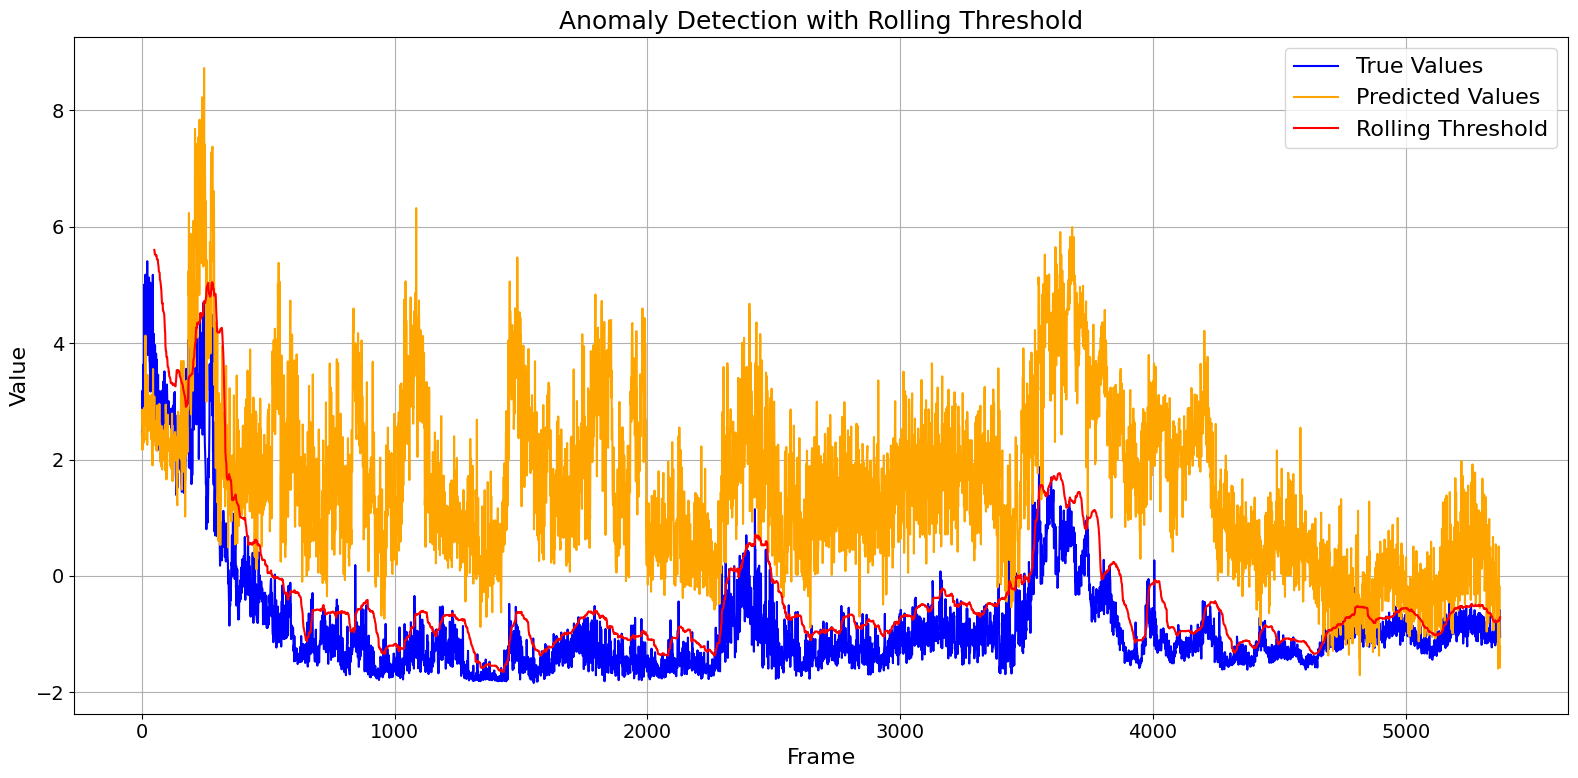

Top Optimal Ranges (Ascending Order):
1. Range: 60 to 210, Score: 1.8015
2. Range: 61 to 210, Score: 1.8082
3. Range: 61 to 210, Score: 1.8082
4. Range: 62 to 210, Score: 1.8132
5. Range: 62 to 210, Score: 1.8132


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8681503646904807
Precision: 0.8734701934465061
Recall  0.9857429271552685
F1 Score: 0.9262166405023547


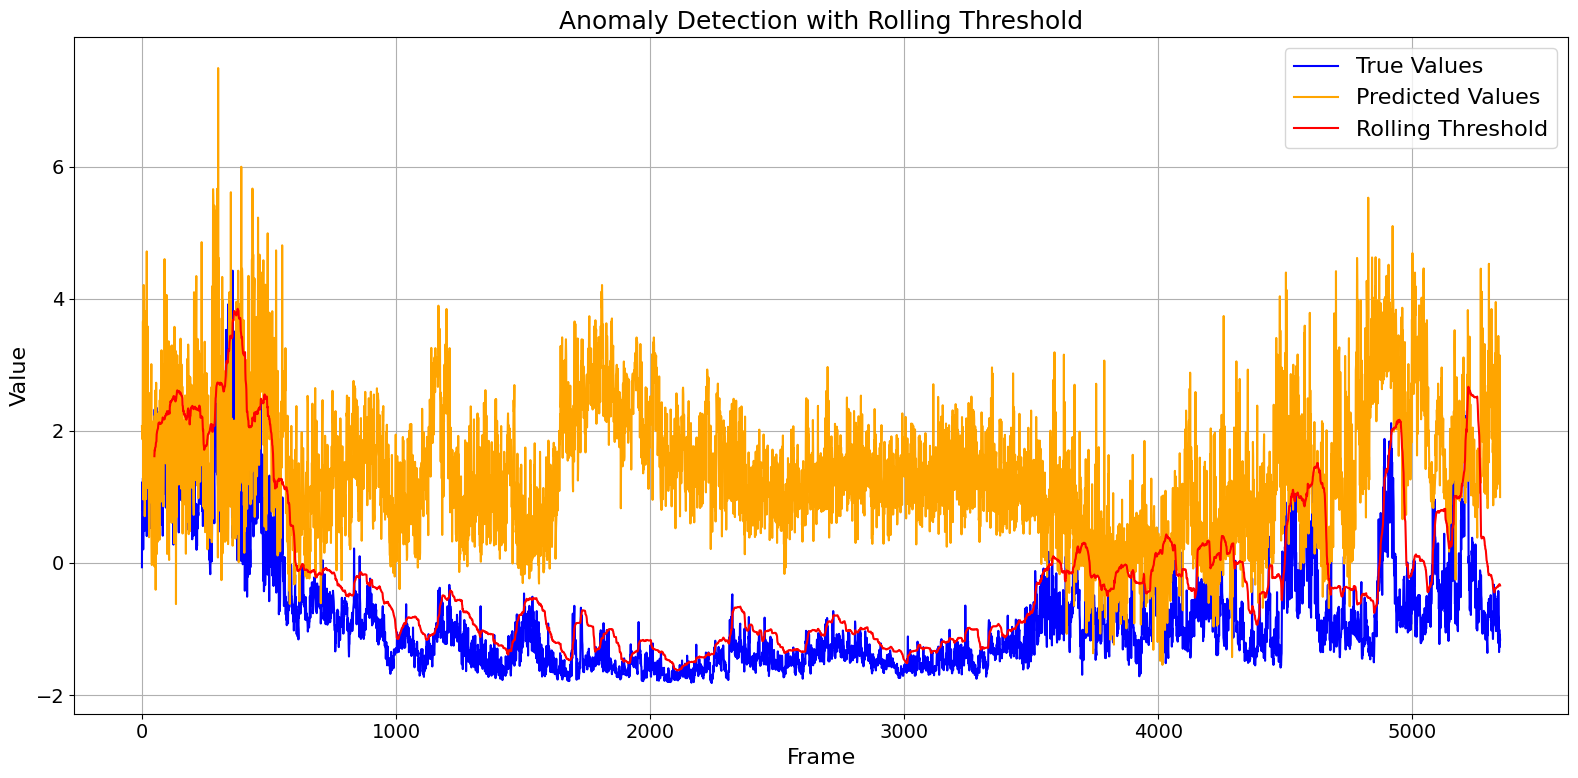

Top Optimal Ranges (Ascending Order):
1. Range: 239 to 389, Score: 2.2575
2. Range: 240 to 389, Score: 2.2582
3. Range: 240 to 389, Score: 2.2582
4. Range: 239 to 388, Score: 2.2587
5. Range: 239 to 388, Score: 2.2587


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8373610081541882
Precision: 0.8453745225045673
Recall  0.9684170471841704
F1 Score: 0.9027223552363217


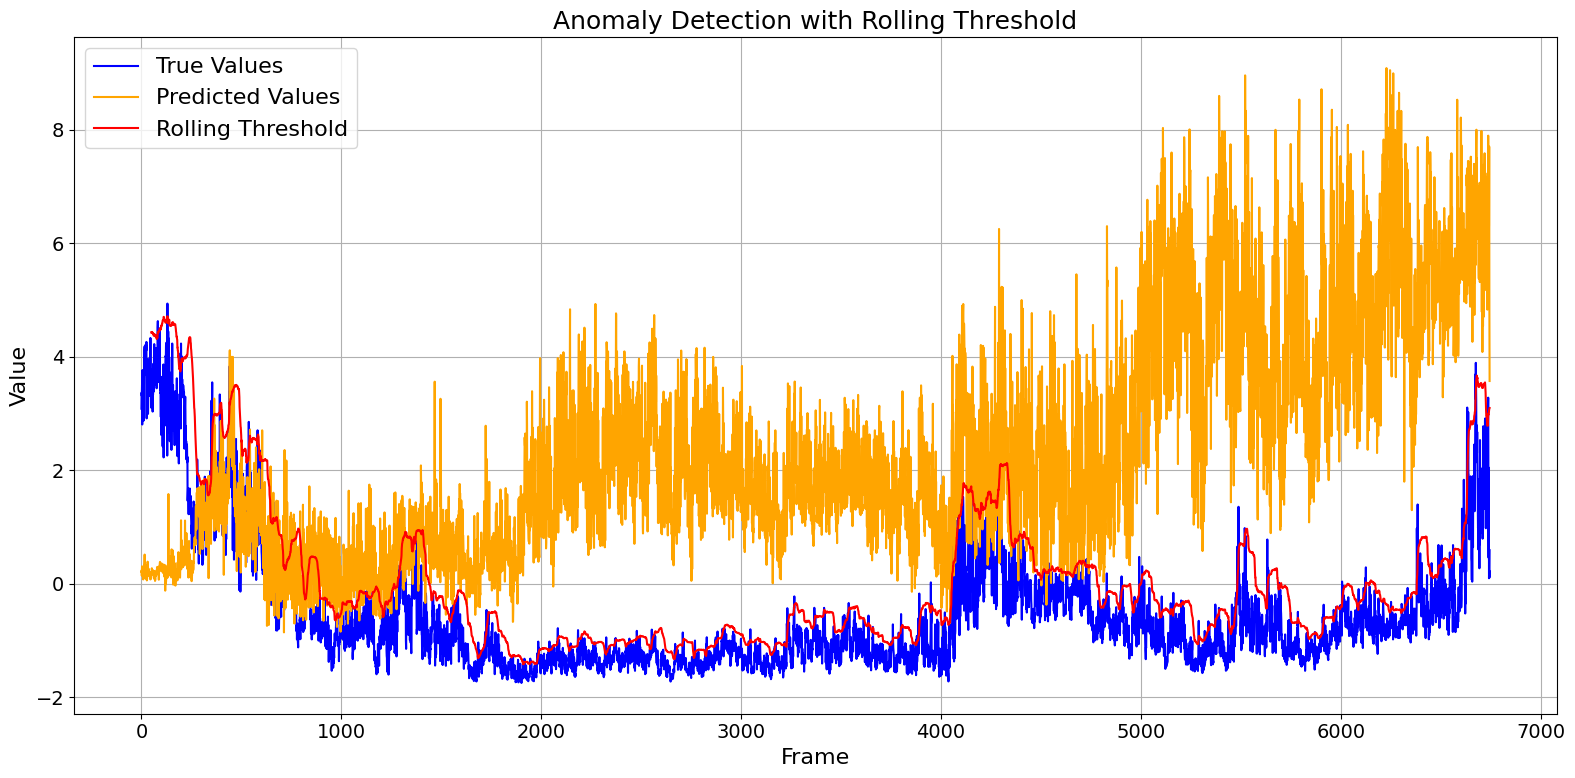

Top Optimal Ranges (Ascending Order):
1. Range: 60 to 210, Score: 0.1889
2. Range: 61 to 210, Score: 0.1895
3. Range: 61 to 210, Score: 0.1895
4. Range: 61 to 211, Score: 0.1902
5. Range: 62 to 210, Score: 0.1903


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7930391547545059
Precision: 0.7928224687933426
Recall  0.9709129511677282
F1 Score: 0.872876503149456


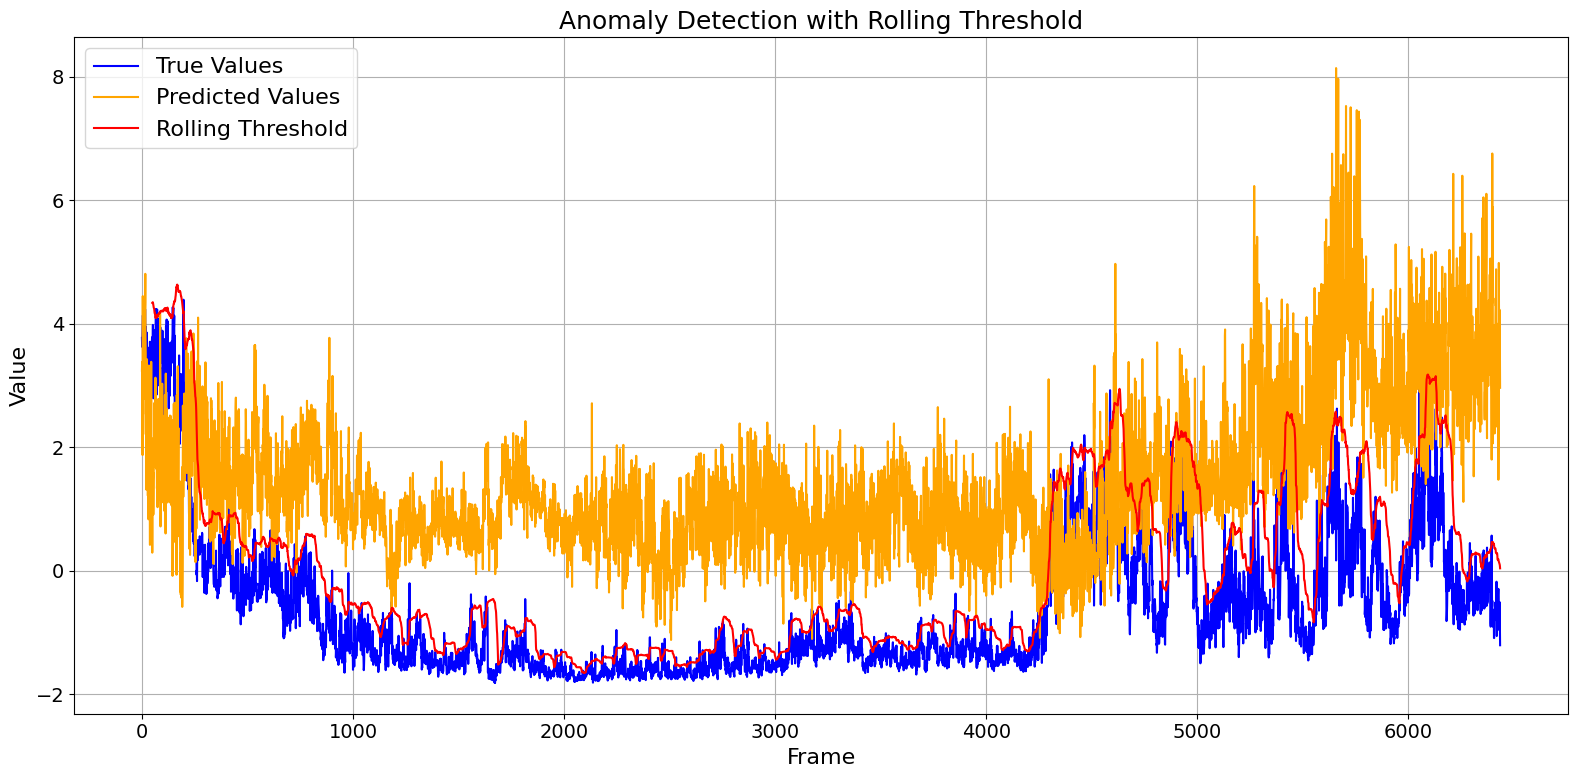

Top Optimal Ranges (Ascending Order):
1. Range: 60 to 210, Score: 1.8719
2. Range: 61 to 210, Score: 1.8826
3. Range: 61 to 210, Score: 1.8826
4. Range: 62 to 210, Score: 1.8928
5. Range: 62 to 210, Score: 1.8928


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8441306037833636
Precision: 0.8375388869685447
Recall  0.9485222156977882
F1 Score: 0.8895823772372649


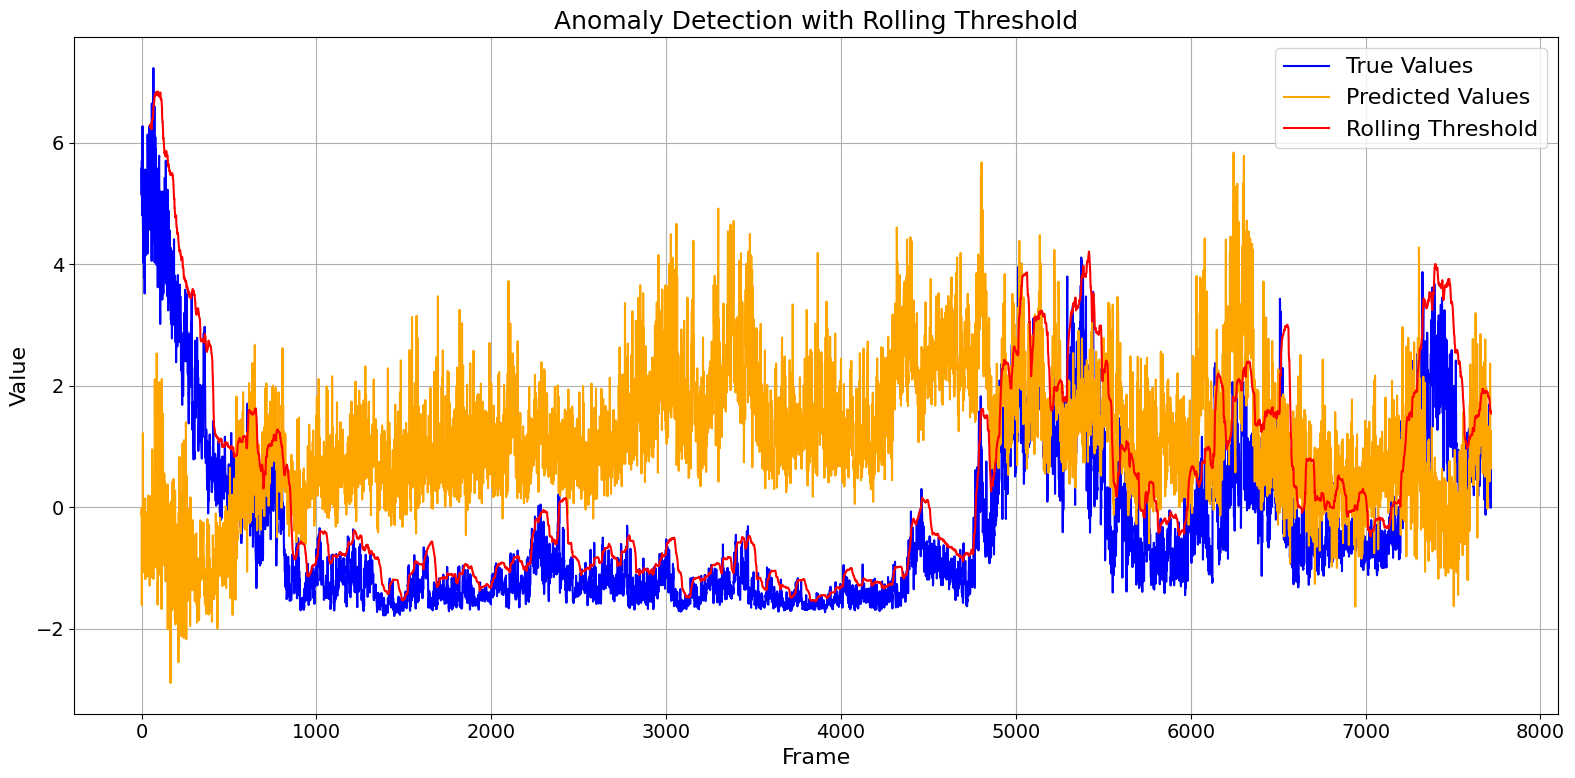

Top Optimal Ranges (Ascending Order):
1. Range: 461 to 611, Score: 0.5495
2. Range: 461 to 610, Score: 0.5513
3. Range: 461 to 610, Score: 0.5513
4. Range: 461 to 609, Score: 0.5520
5. Range: 461 to 609, Score: 0.5520


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9904413831880798
Precision: 0.9903078677309008
Recall  1.0
F1 Score: 0.9951303351475222


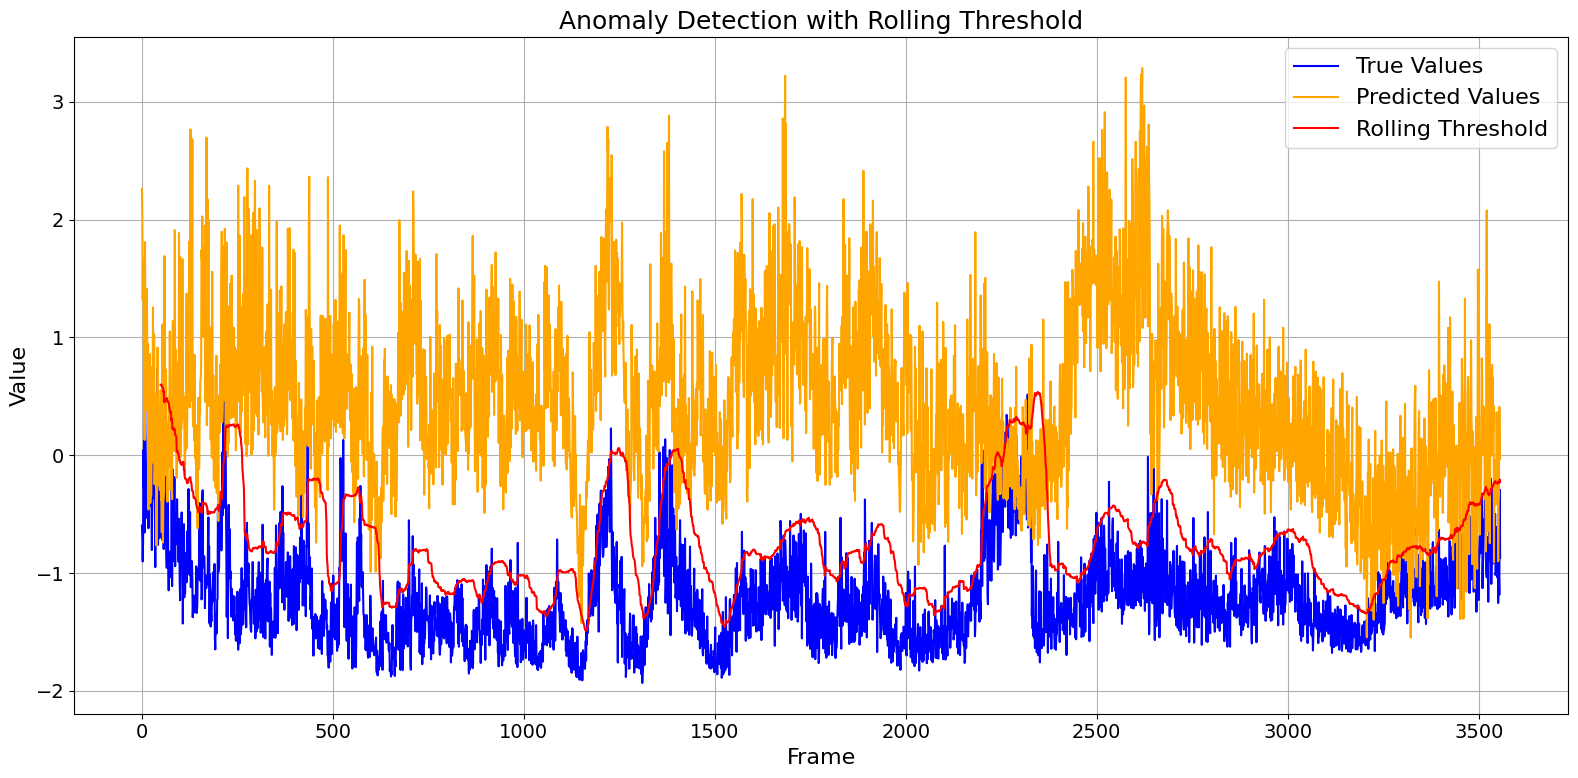

Top Optimal Ranges (Ascending Order):
1. Range: 2245 to 2395, Score: 2.3687
2. Range: 2245 to 2394, Score: 2.3690
3. Range: 2245 to 2394, Score: 2.3690
4. Range: 2244 to 2394, Score: 2.3694
5. Range: 2246 to 2395, Score: 2.3694


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8778625954198473
Precision: 0.8916385451818523
Recall  0.9647058823529412
F1 Score: 0.926734216679657


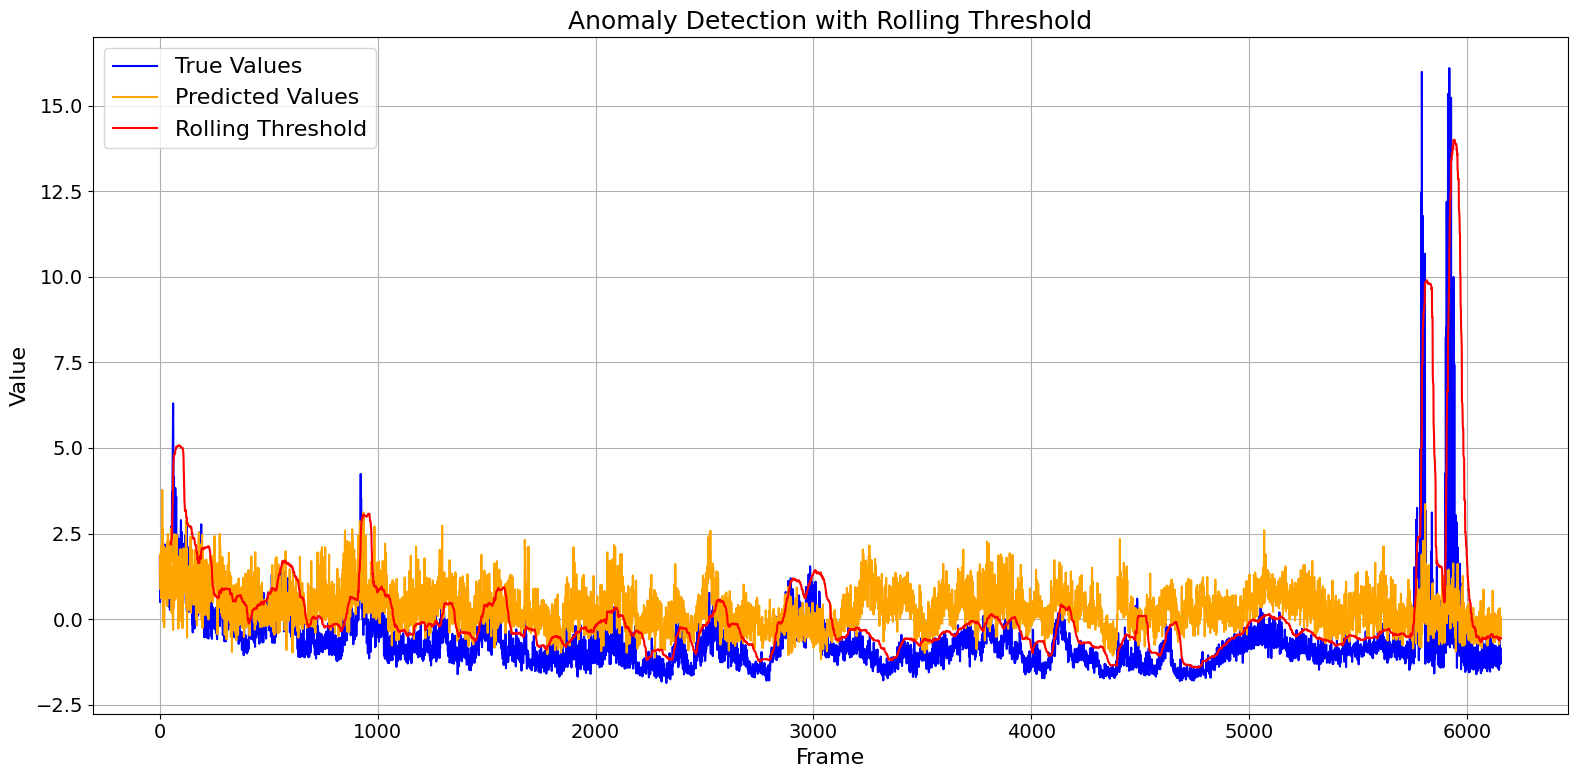

Top Optimal Ranges (Ascending Order):
1. Range: 2844 to 2994, Score: 0.7969
2. Range: 2846 to 2994, Score: 0.7979
3. Range: 2846 to 2994, Score: 0.7979
4. Range: 2845 to 2994, Score: 0.7983
5. Range: 2845 to 2994, Score: 0.7983


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8442468798085143
Precision: 0.8437788870401183
Recall  0.9857451403887689
F1 Score: 0.9092539097519673


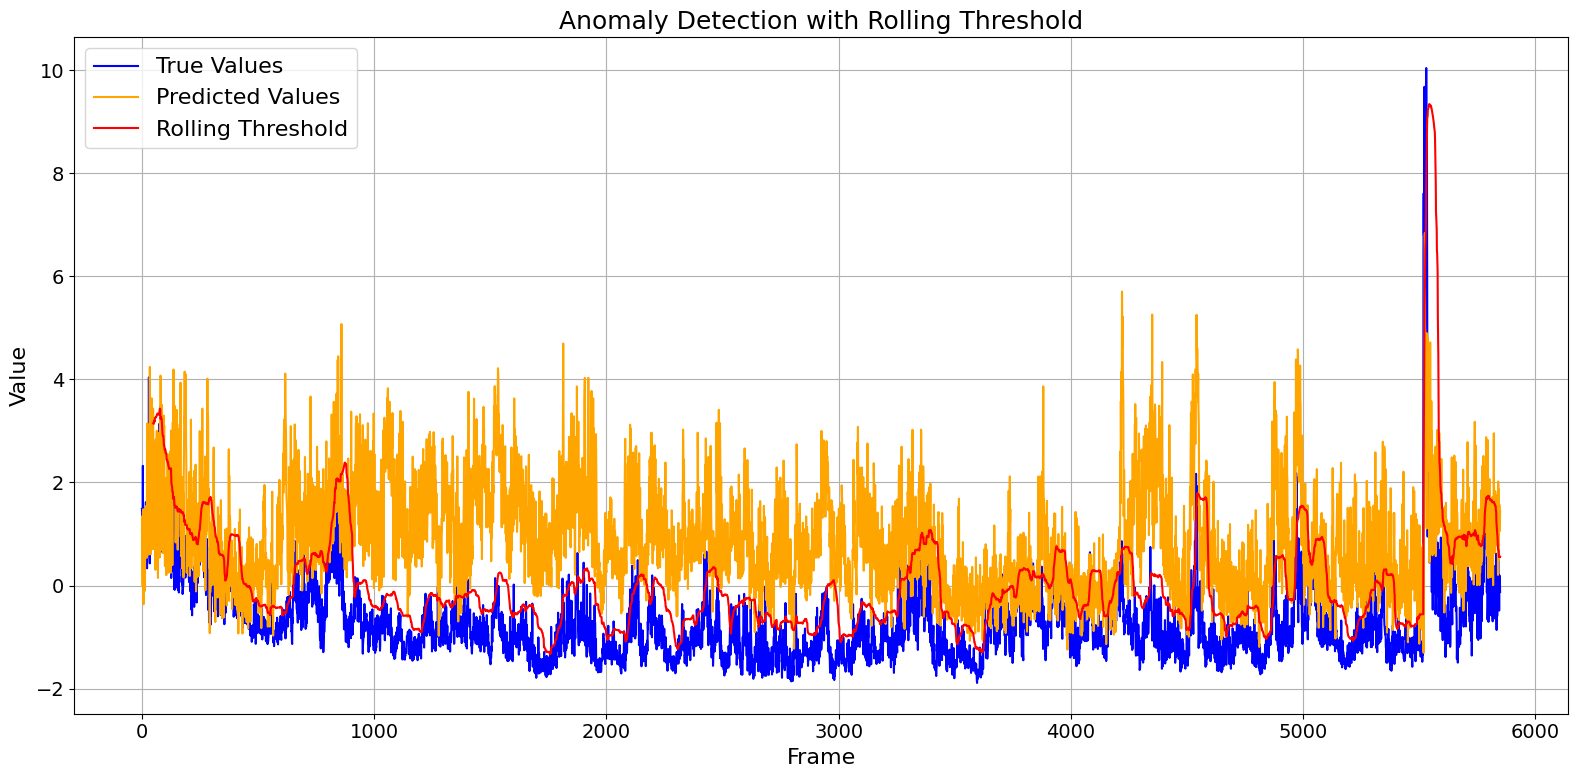

Top Optimal Ranges (Ascending Order):
1. Range: 5371 to 5521, Score: 1.8401
2. Range: 5372 to 5521, Score: 1.8433
3. Range: 5372 to 5521, Score: 1.8433
4. Range: 5372 to 5522, Score: 1.8466
5. Range: 5373 to 5521, Score: 1.8468


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9906873614190688
Precision: 0.9937471051412691
Recall  0.9965164886205294
F1 Score: 0.9951298701298701


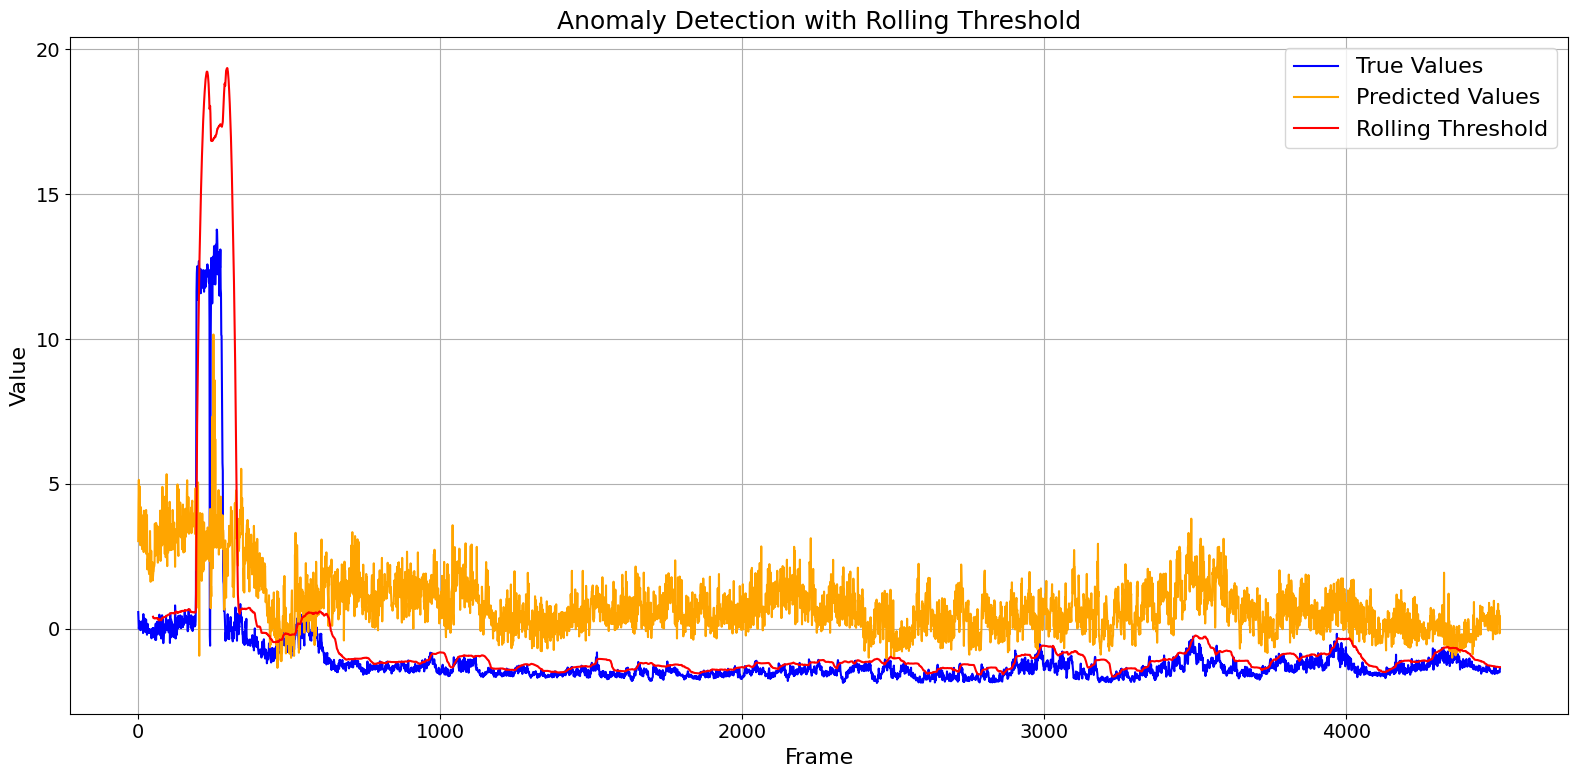

Top Optimal Ranges (Ascending Order):
1. Range: 145 to 295, Score: 2.1450
2. Range: 145 to 294, Score: 2.1471
3. Range: 145 to 294, Score: 2.1471
4. Range: 145 to 293, Score: 2.1490
5. Range: 145 to 293, Score: 2.1490


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9019143117593437
Precision: 0.9106037151702786
Recall  0.9841070681723129
F1 Score: 0.9459296482412061


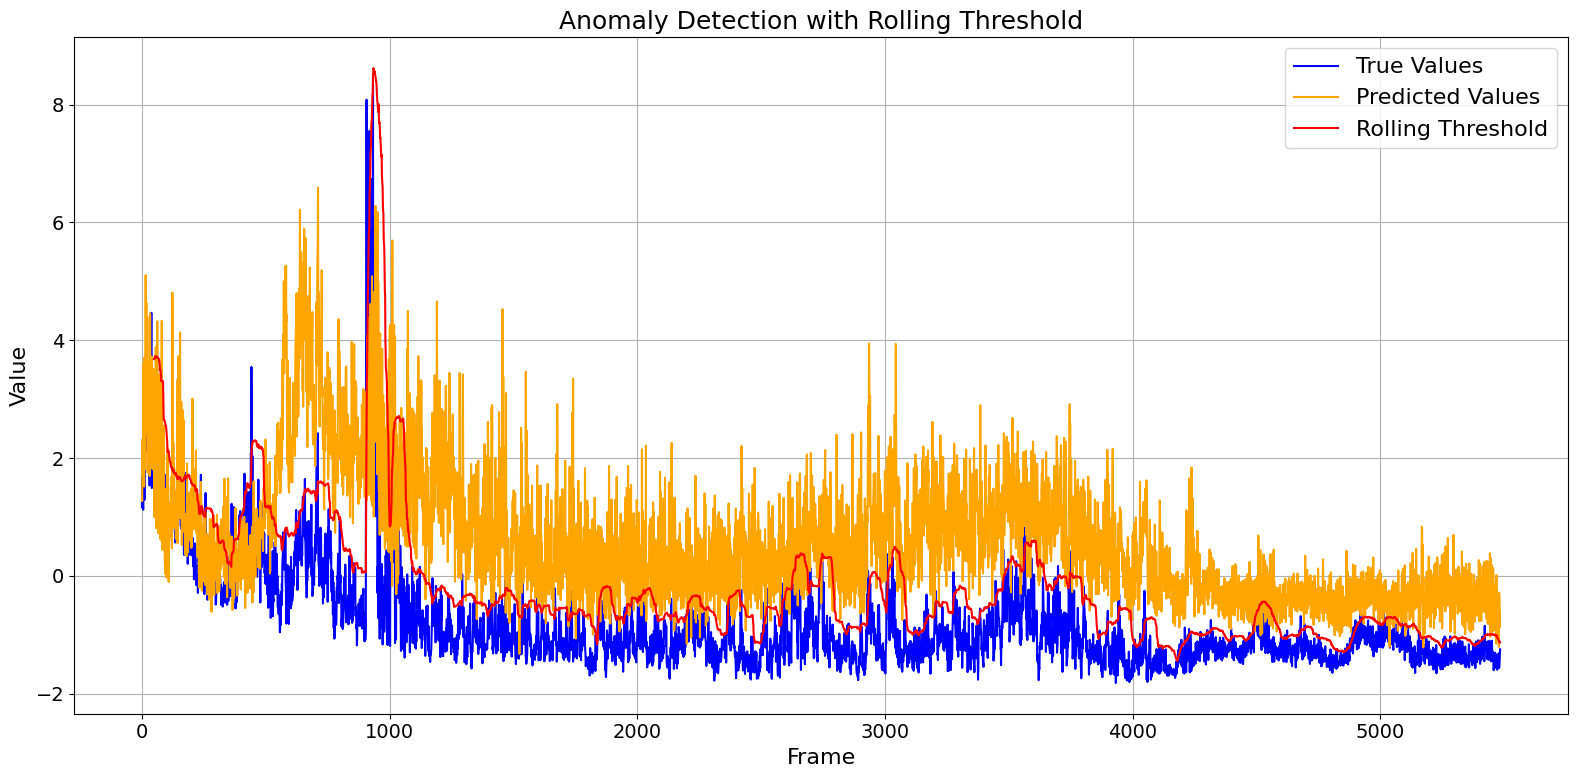

Top Optimal Ranges (Ascending Order):
1. Range: 331 to 481, Score: 1.0351
2. Range: 331 to 478, Score: 1.0355
3. Range: 331 to 478, Score: 1.0355
4. Range: 331 to 479, Score: 1.0356
5. Range: 331 to 479, Score: 1.0356


In [9]:
pred = []
for args in arg_list:
    pred.append(bootstrapping_function(args))

In [37]:
pred[0].shape

(9727, 1)

Entire dataset saved to output_full_range.csv


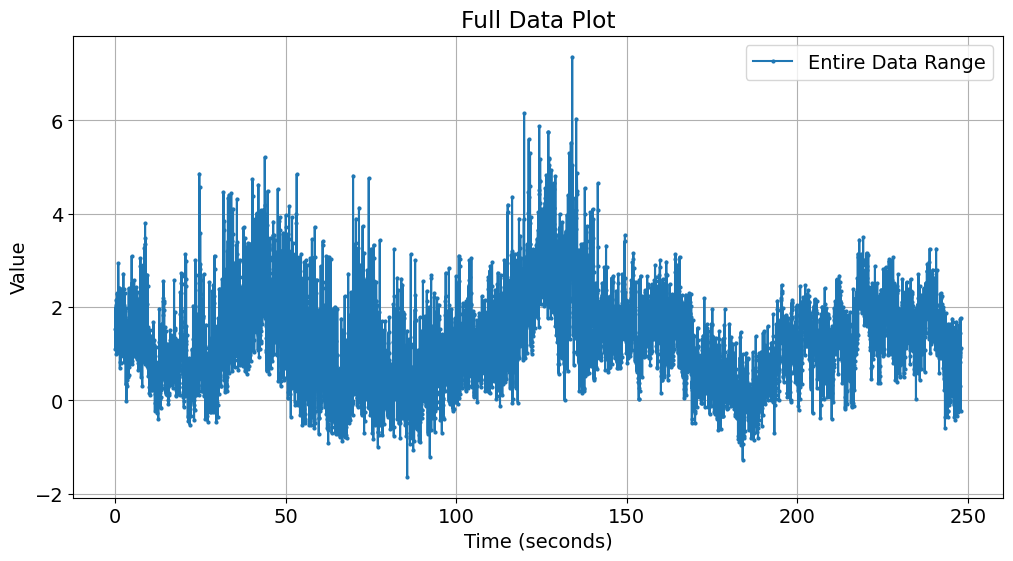

In [43]:
plot_and_save_all_frames(np.array(pred[1]), 30)

Data saved to output_range.csv


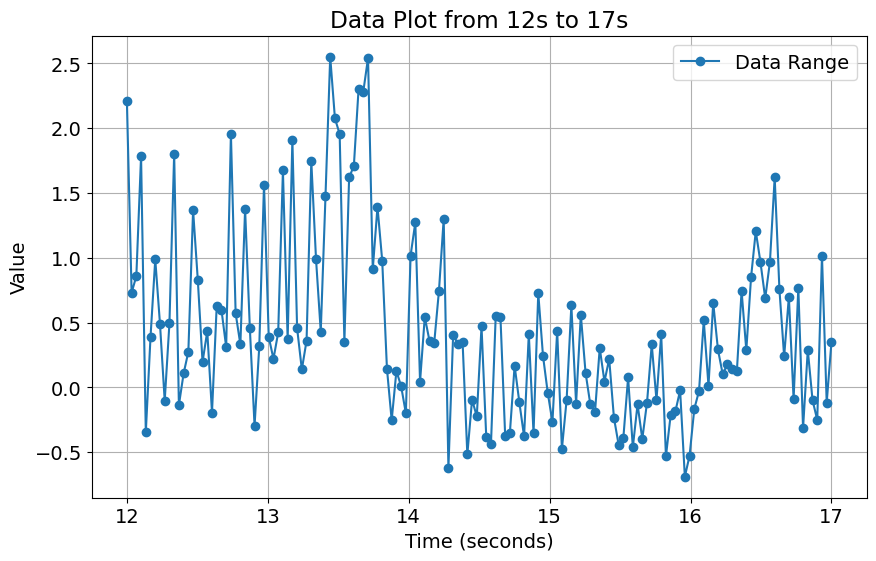

In [38]:
plot_and_save_range_frames(np.array(pred[0]), 12, 17, 30)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7583148558758315
Precision: 0.5088757396449705
Recall  0.3891402714932127
F1 Score: 0.441025641025641


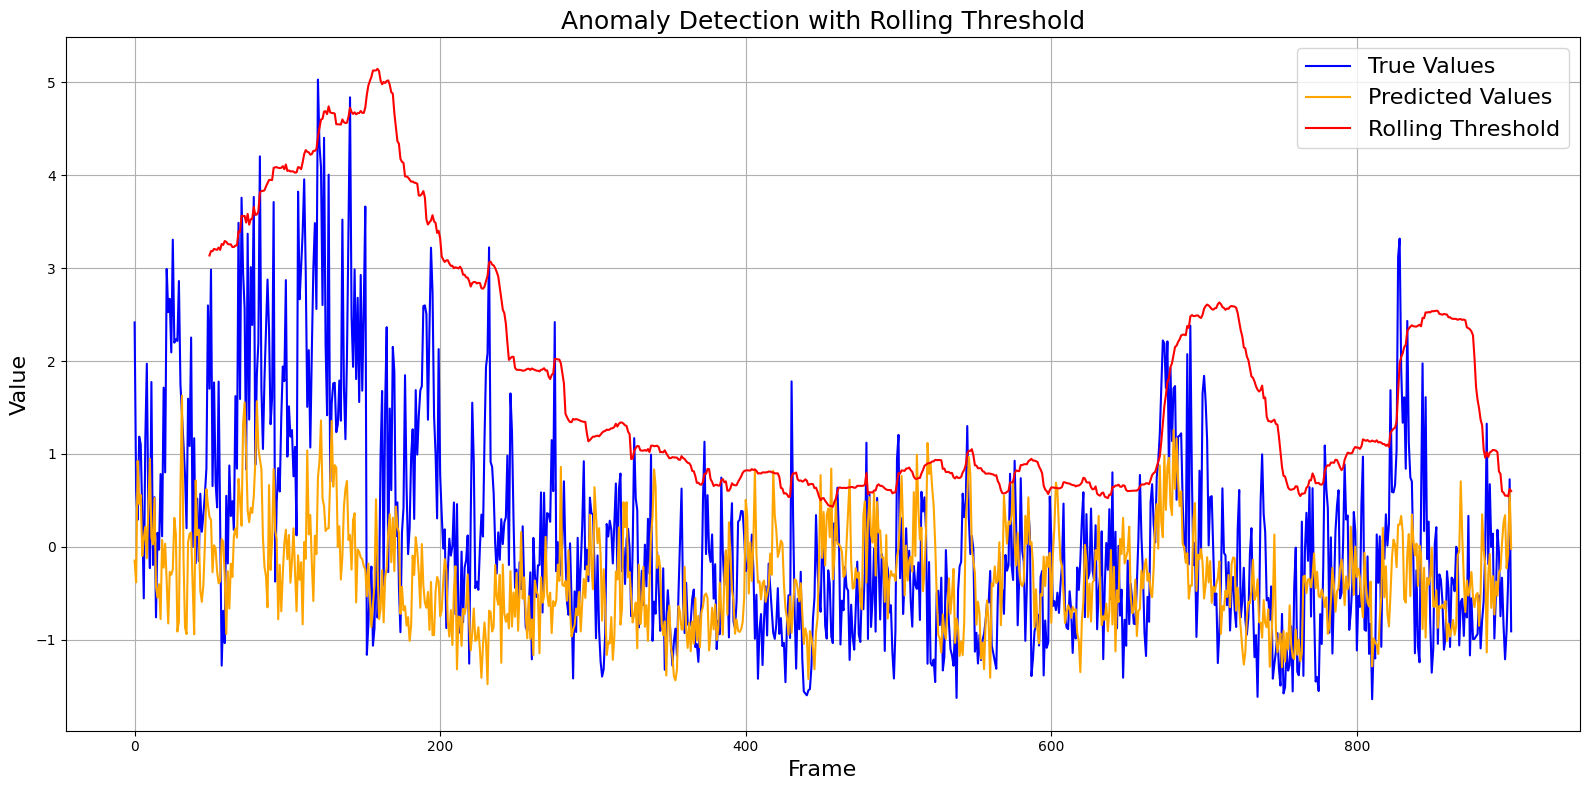

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7137254901960784
Precision: 0.6571428571428571
Recall  0.4842105263157895
F1 Score: 0.5575757575757576


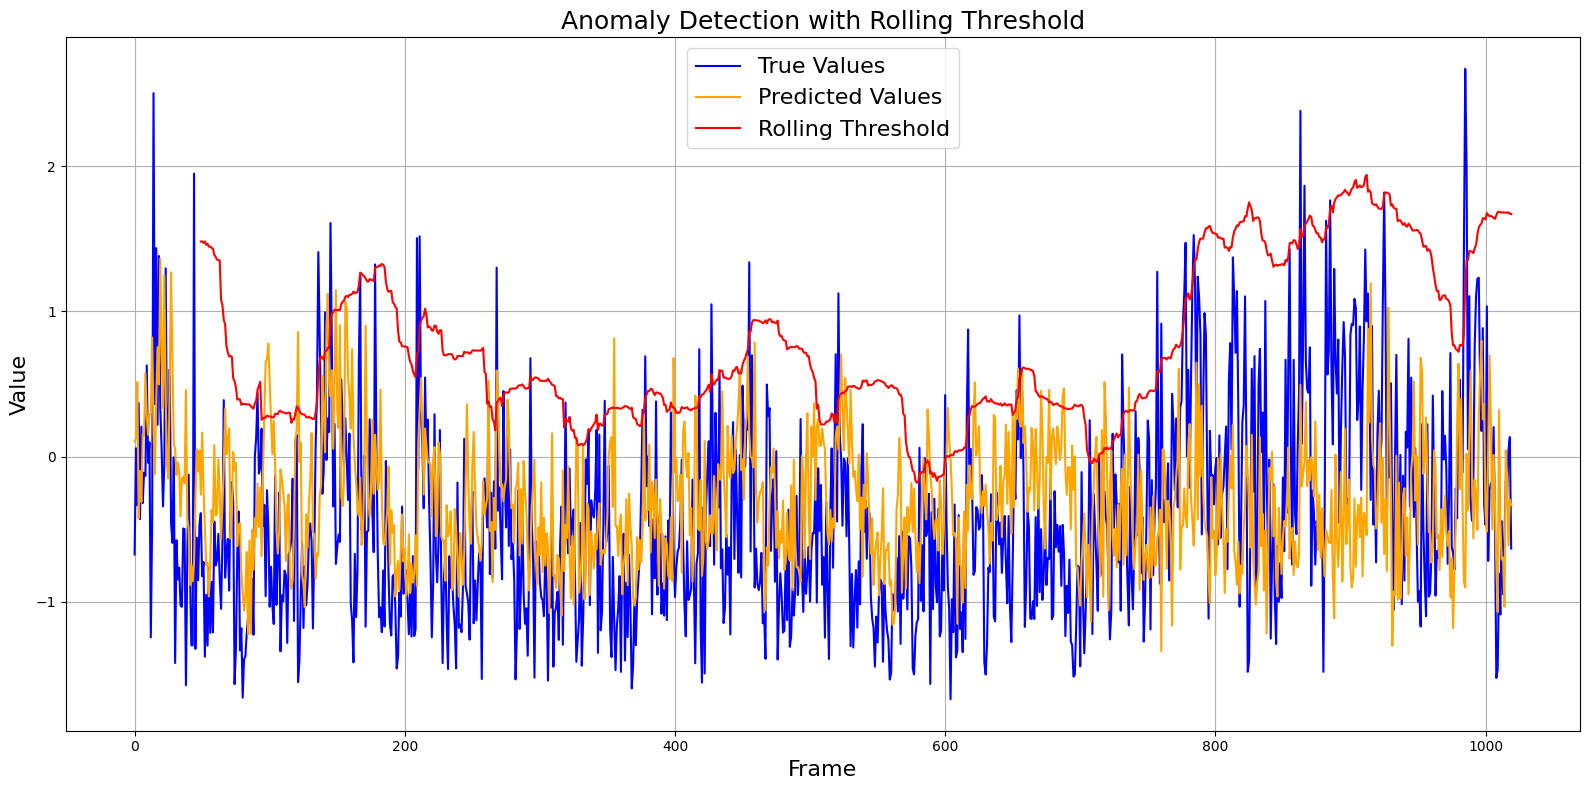

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8649155722326454
Precision: 0.32061068702290074
Recall  0.4329896907216495
F1 Score: 0.3684210526315789


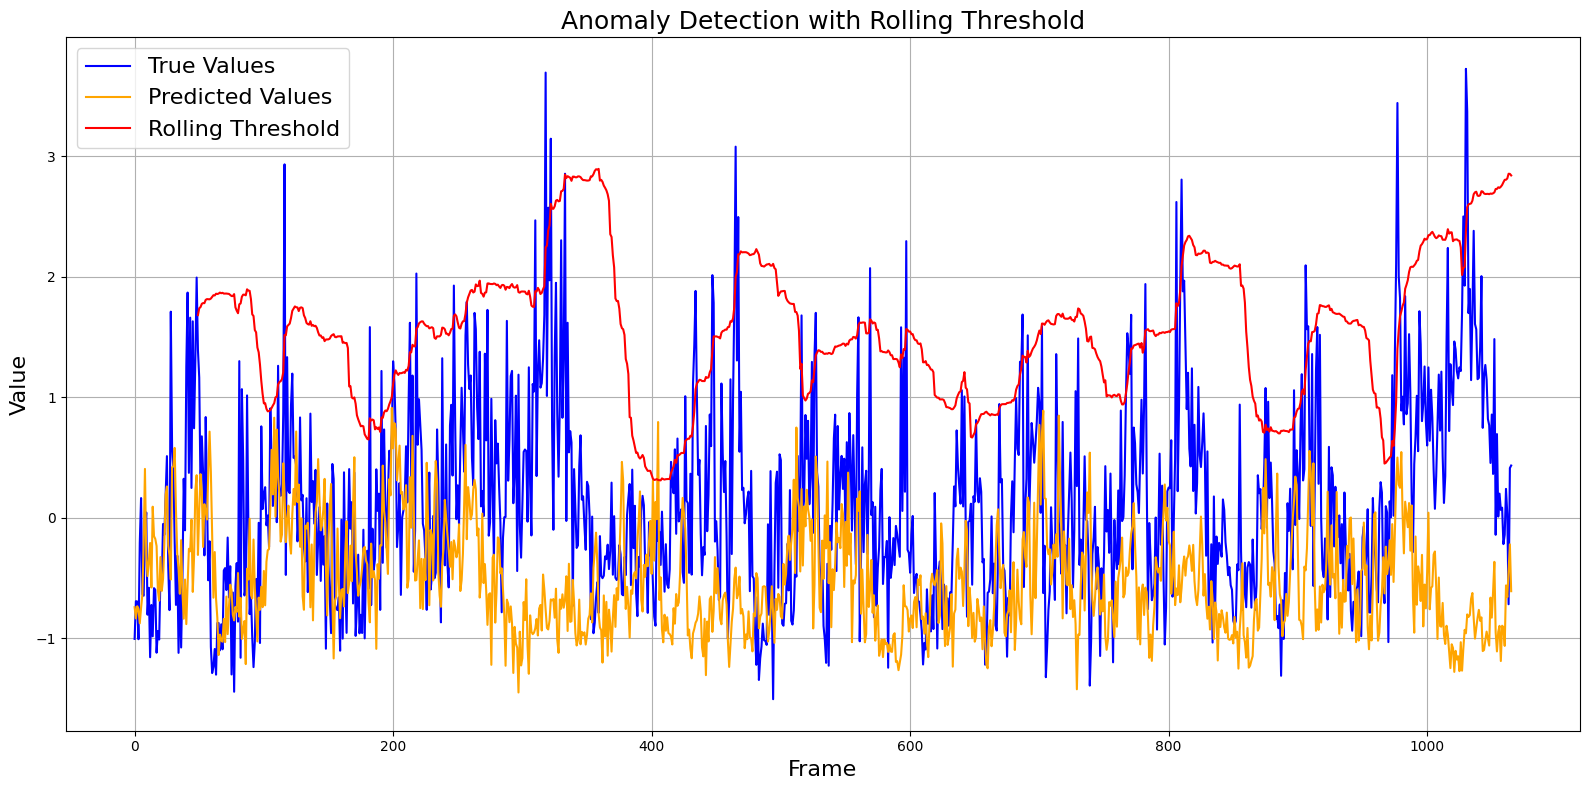

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7757805108798487
Precision: 0.6796657381615598
Recall  0.6666666666666666
F1 Score: 0.6731034482758621


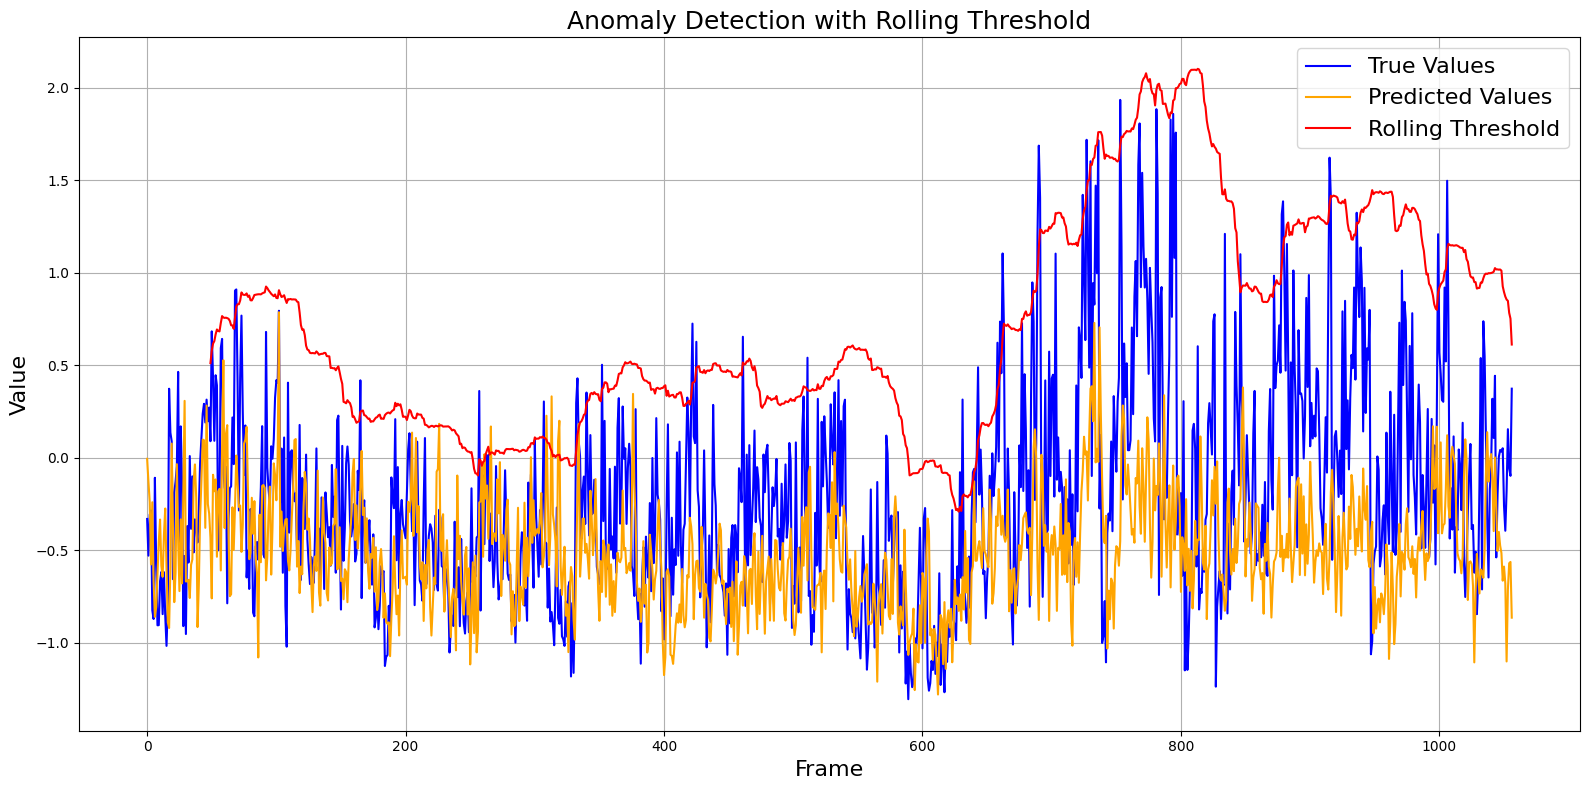

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8592351505288853
Precision: 0.7774193548387097
Recall  0.6985507246376812
F1 Score: 0.7358778625954199


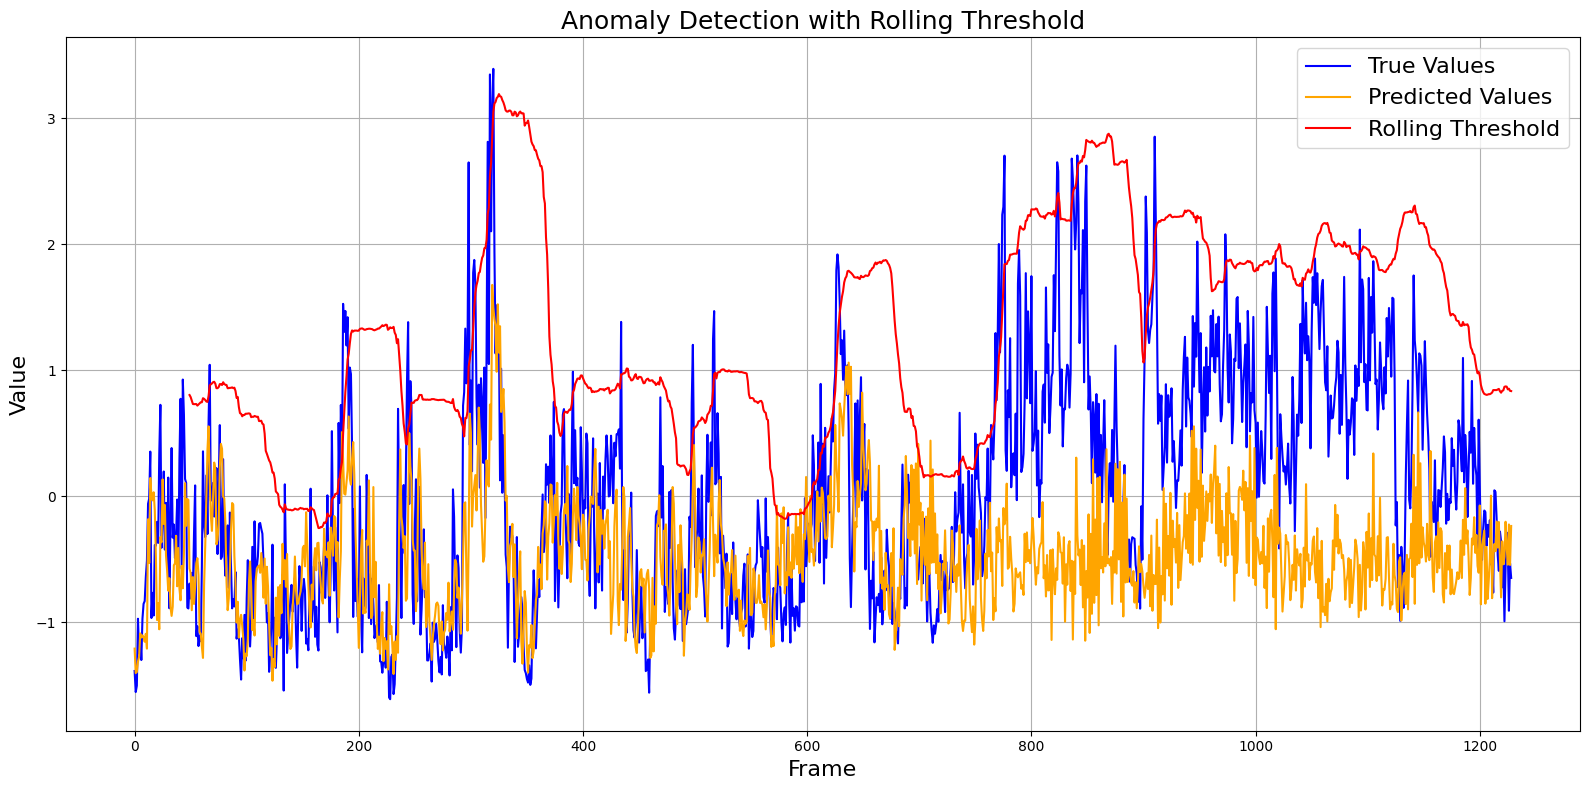

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.768303985171455
Precision: 0.7790432801822323
Recall  0.6909090909090909
F1 Score: 0.7323340471092077


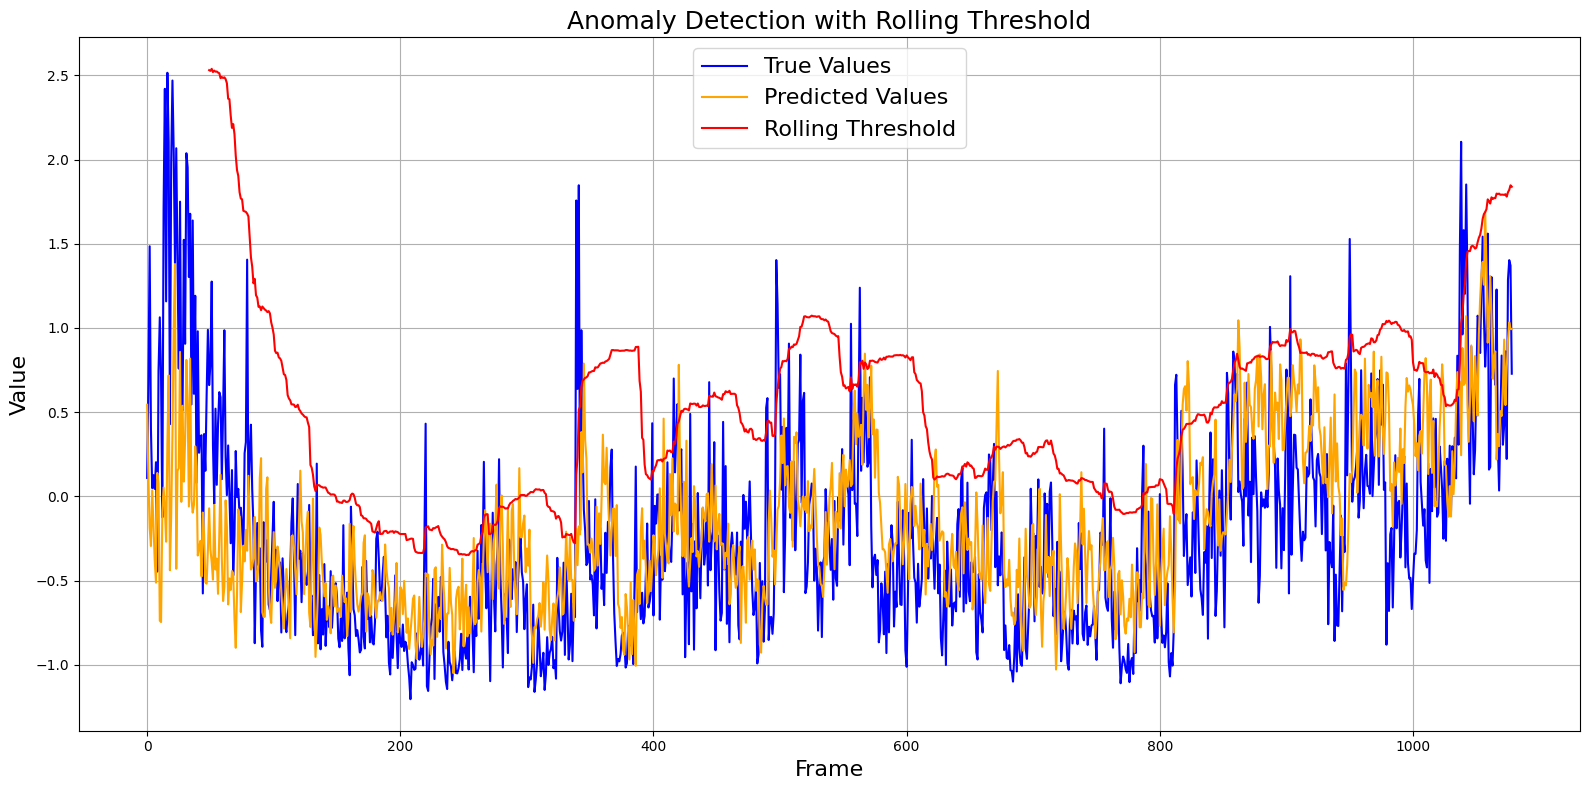

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9025297619047619
Precision: 0.7189189189189189
Recall  0.6273584905660378
F1 Score: 0.6700251889168766


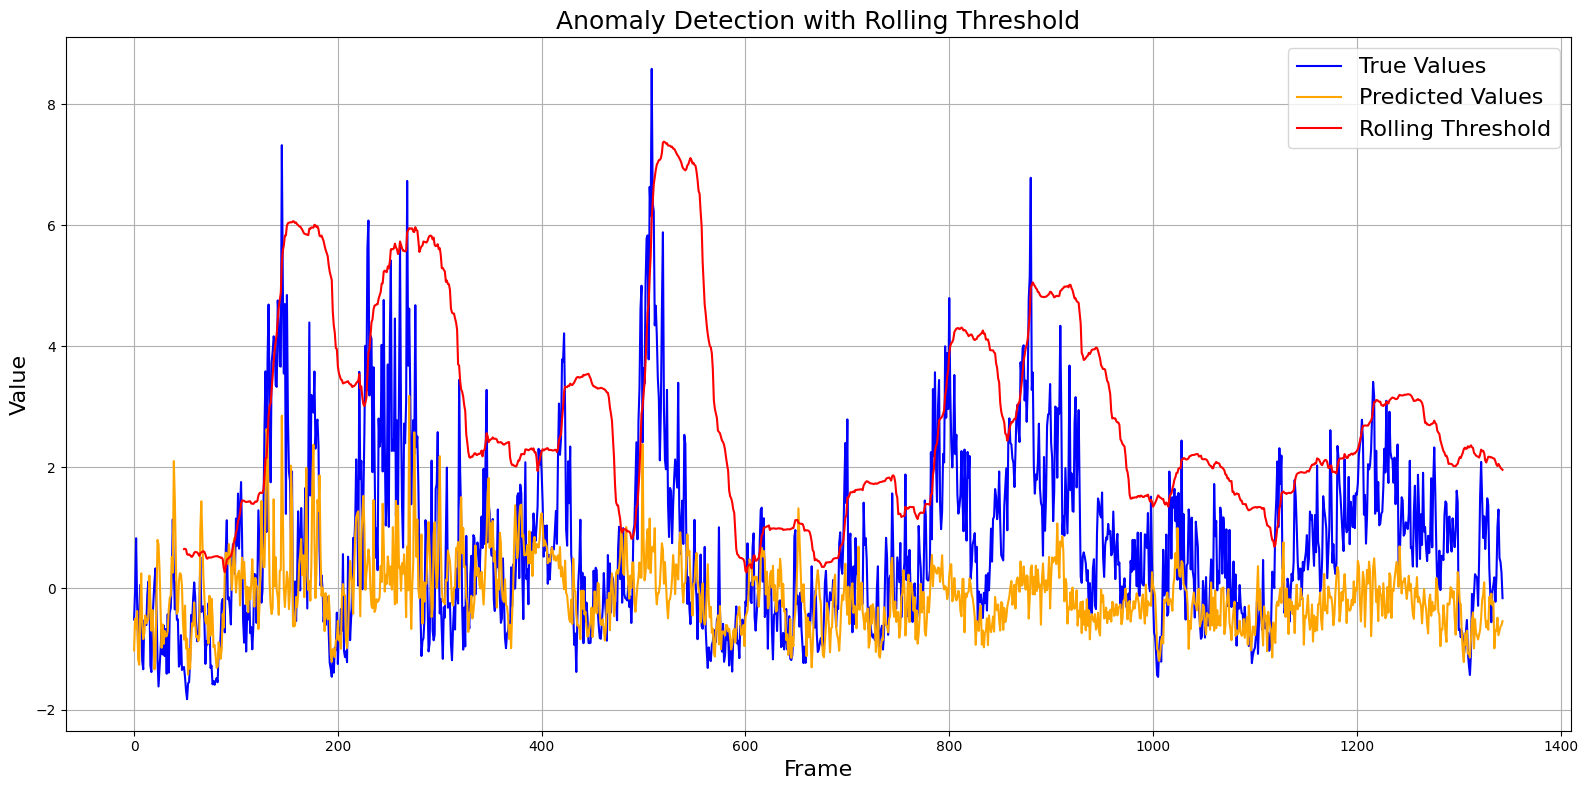

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8349282296650717
Precision: 0.8288973384030418
Recall  0.7009646302250804
F1 Score: 0.759581881533101


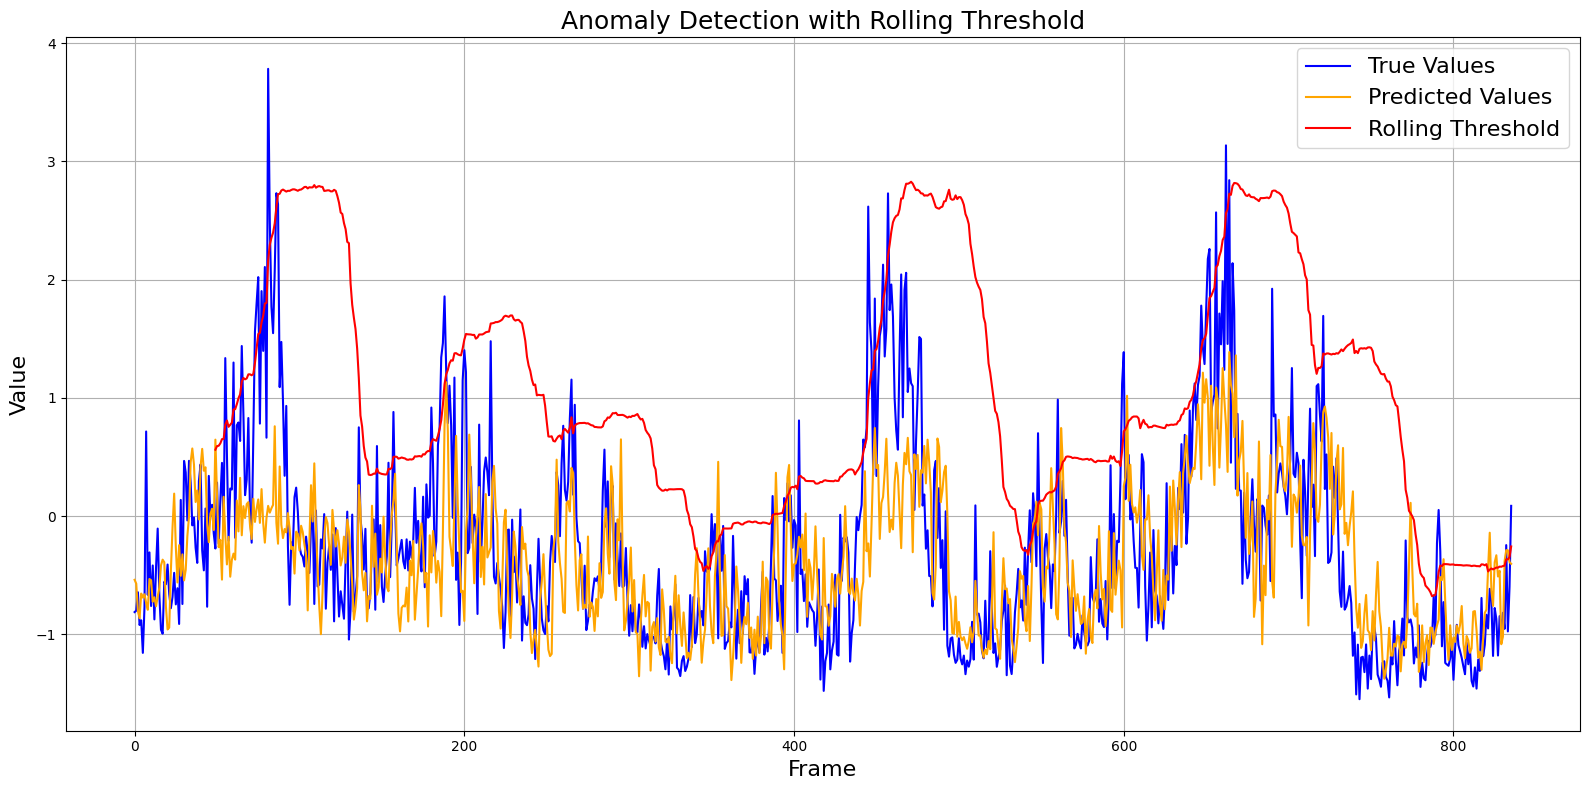

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8002092050209205
Precision: 0.7591623036649214
Recall  0.8913934426229508
F1 Score: 0.8199811498586239


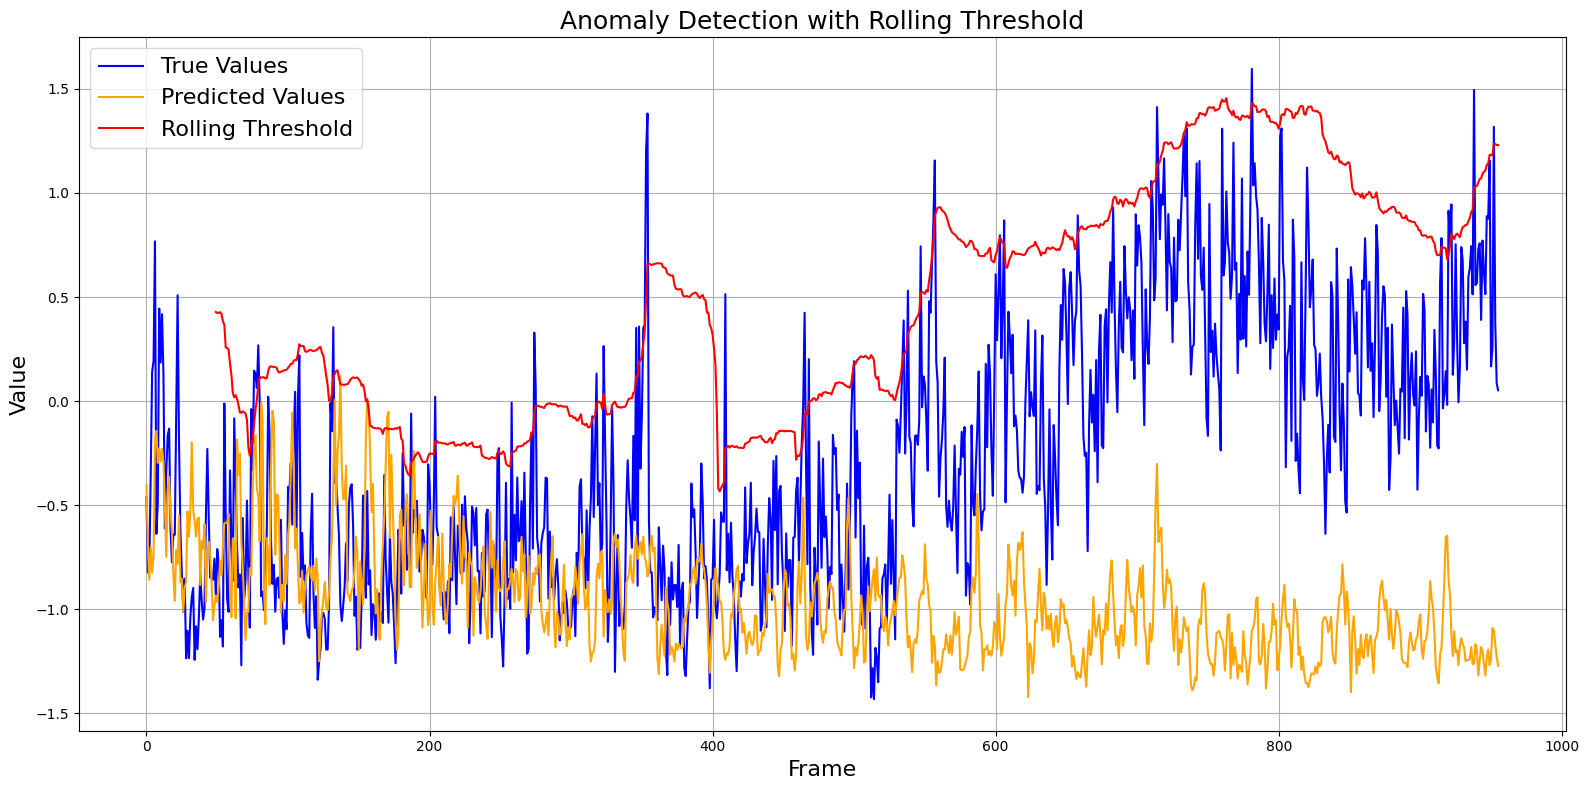

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7806859205776173
Precision: 0.8206724782067247
Recall  0.8693931398416886
F1 Score: 0.8443305573350416


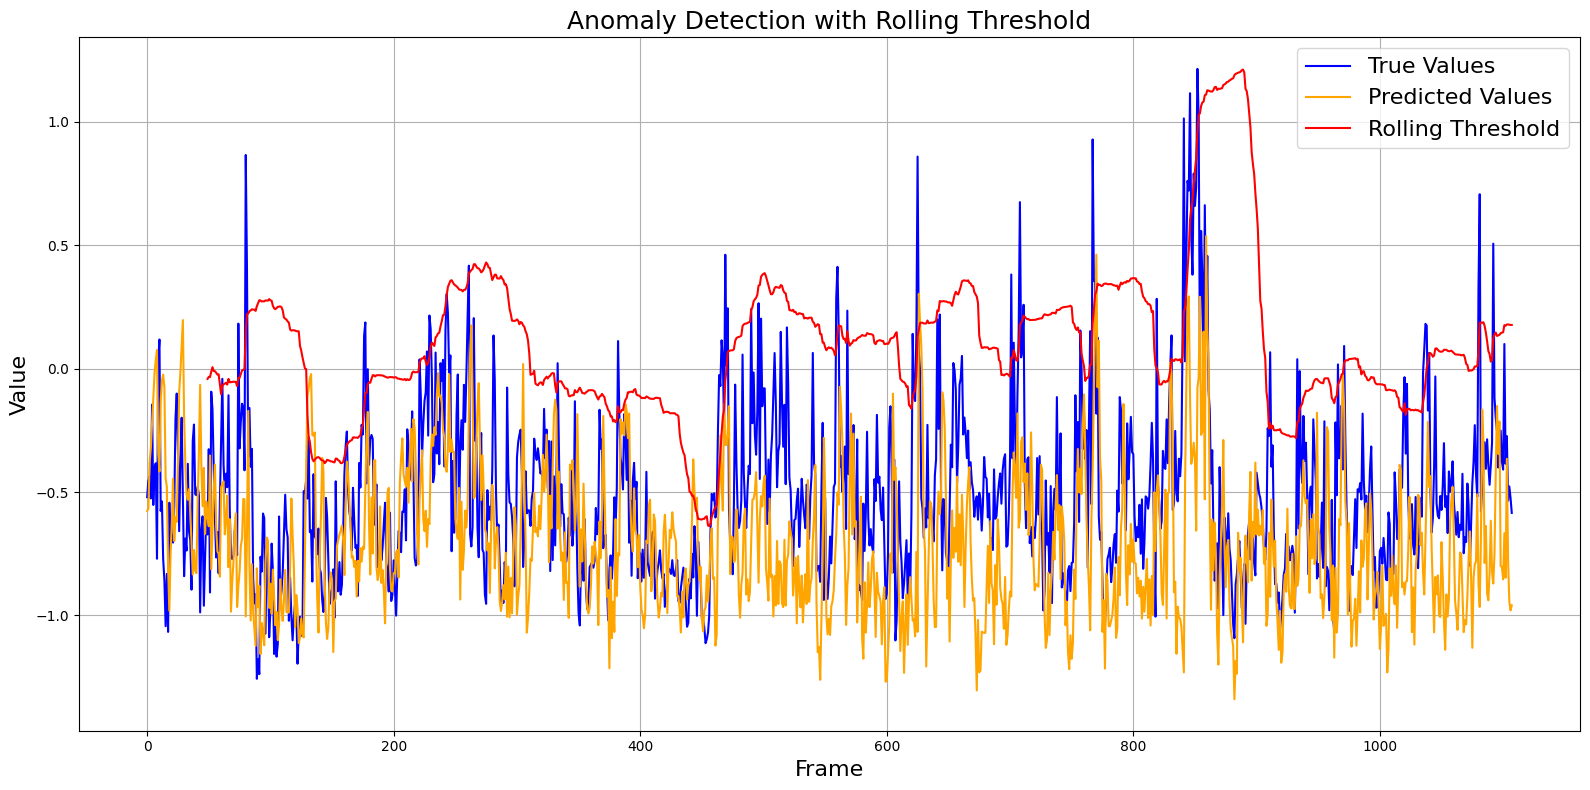

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7330791229742613
Precision: 0.8117283950617284
Recall  0.5456431535269709
F1 Score: 0.652605459057072


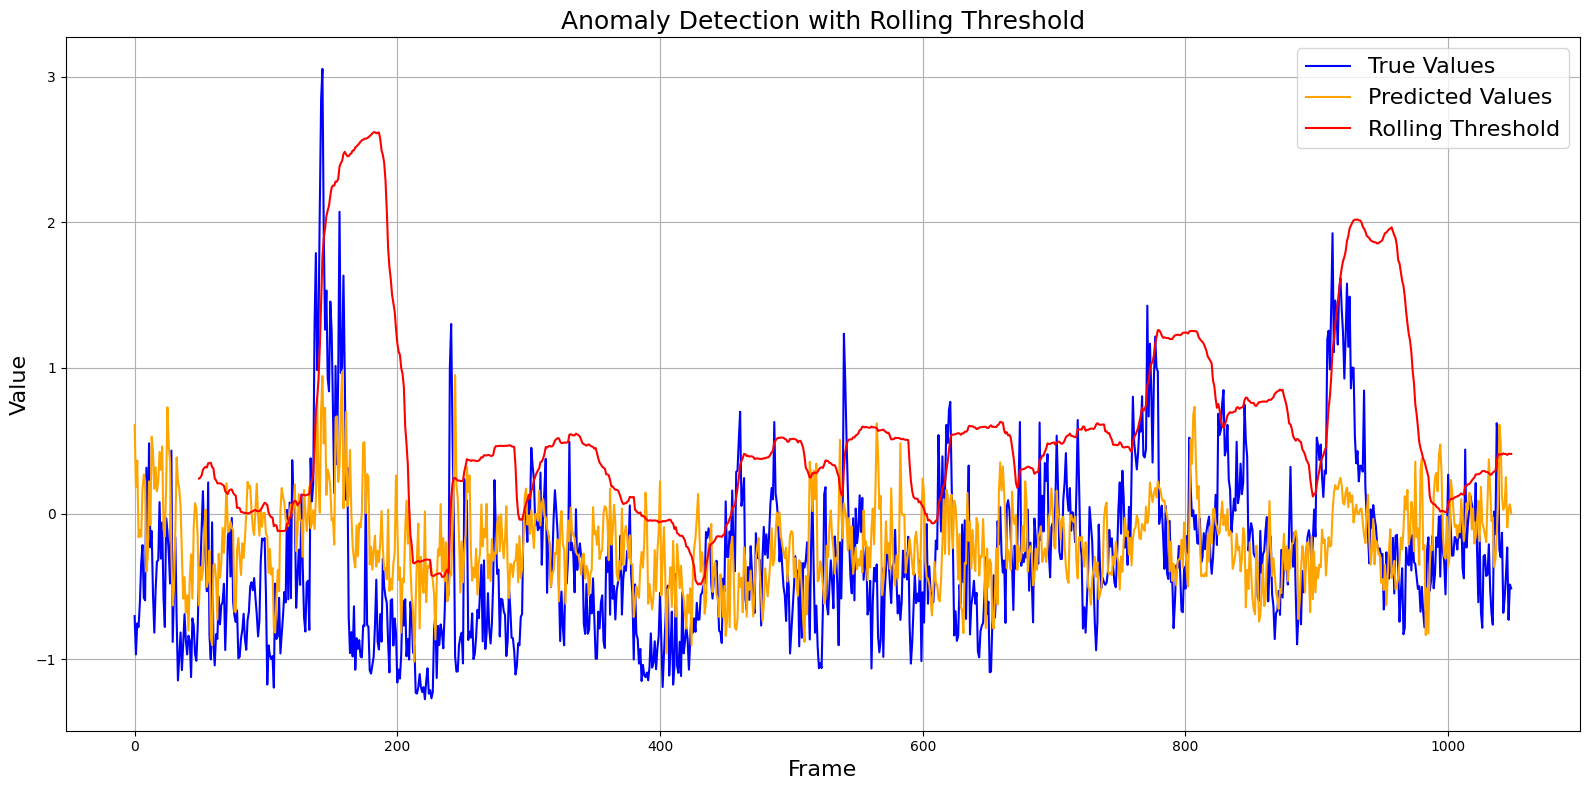

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7708978328173375
Precision: 0.7248677248677249
Recall  0.44625407166123776
F1 Score: 0.5524193548387096


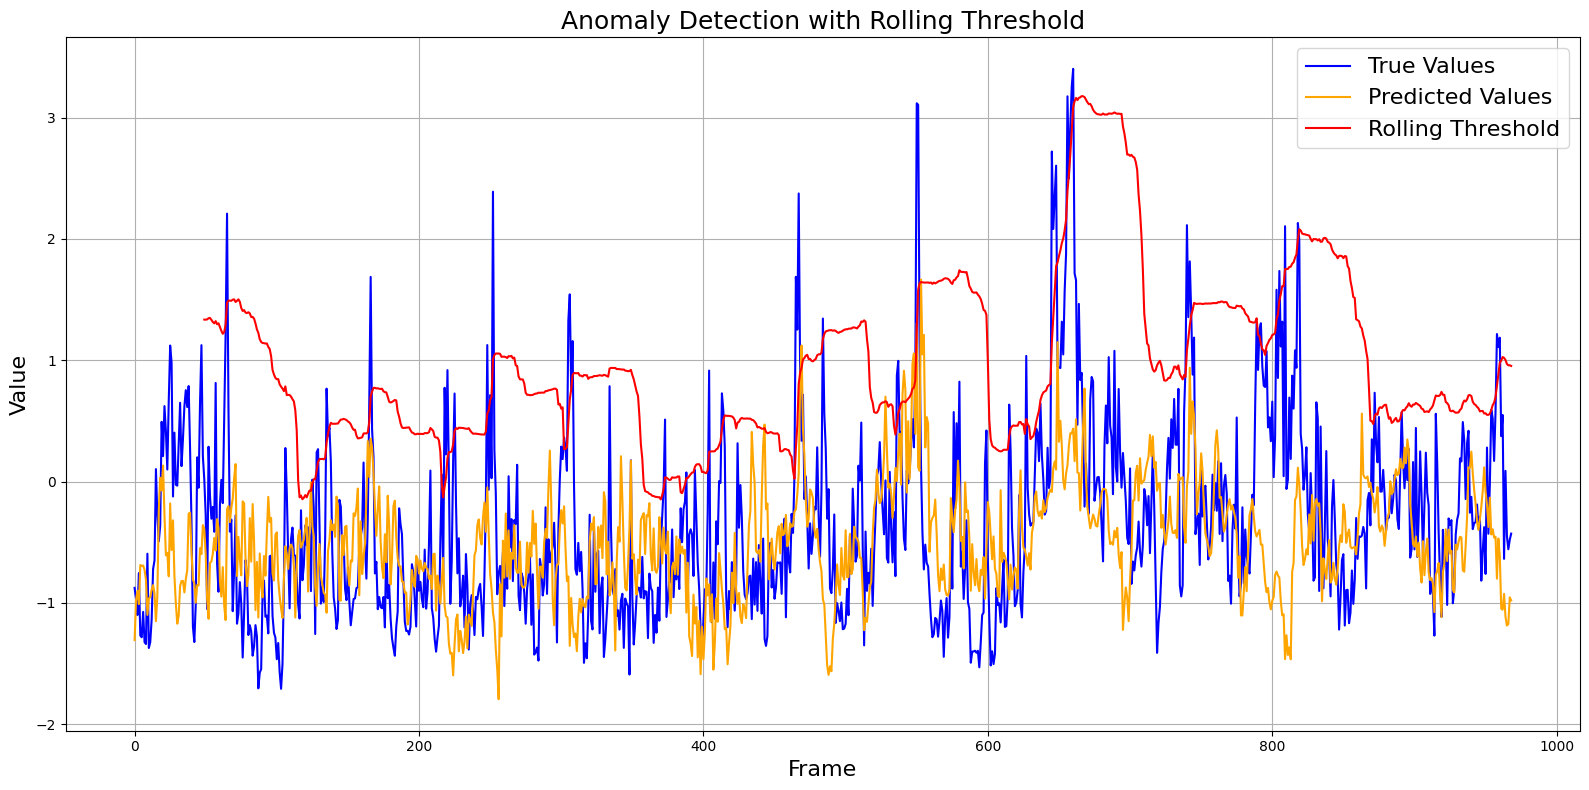

In [73]:
for args in arg_list:
    regular_function(args)

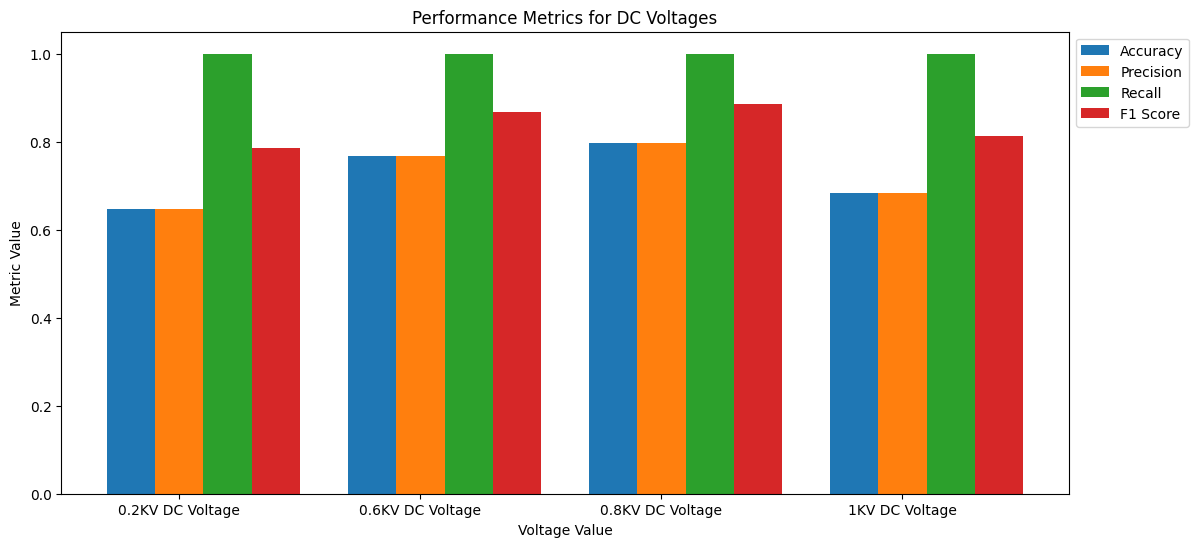

In [26]:
import matplotlib.pyplot as plt

ac_data = pd.DataFrame({
    "Testcase": ["0.5KV AC Voltage", "1KV AC Voltage", "2KV AC Voltage", "3KV AC Voltage"],
    "Accuracy": [0.9282051282051282, 0.8689655172413793, 0.6043307086614174, 0.9282051282051282],
    "Precision": [0.928205128205, 0.8689655172413793, 0.6043307086614174, 0.928205128205],
    "Recall": [1.0, 1.0, 1.0, 1.0],
    "F1 Score": [0.9627659574468085, 0.9298892988929889, 0.7533742331288343, 0.9627659574468085]
})

# DC Data
dc_data = pd.DataFrame({
    "Testcase": ["0.2KV DC Voltage", "0.6KV DC Voltage", "0.8KV DC Voltage", "1KV DC Voltage"],
    "Accuracy": [0.6460905349794238, 0.767379679144385, 0.7961165048543689, 0.6842105263157895],
    "Precision": [0.6460905349794238, 0.767379679144385, 0.7961165048543689, 0.6842105263157895],
    "Recall": [1.0, 1.0, 1.0, 1.0],
    "F1 Score": [0.7849999999999999, 0.8683812405446293, 0.8864864864864864, 0.8125]
})

# Assuming `ac_data` and `dc_data` DataFrames contain the data for AC and DC voltages


# Plot for DC voltages
plt.figure(figsize=(13, 6))
x = range(len(dc_data['Testcase']))
plt.bar([i - 0.2 for i in x], dc_data['Accuracy'], width=0.2, label='Accuracy', align='center')
plt.bar([i for i in x], dc_data['Precision'], width=0.2, label='Precision', align='center')
plt.bar([i + 0.2 for i in x], dc_data['Recall'], width=0.2, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], dc_data['F1 Score'], width=0.2, label='F1 Score', align='center')
plt.xticks(x, dc_data['Testcase'])
plt.title('Performance Metrics for DC Voltages')
plt.xlabel('Voltage Value')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


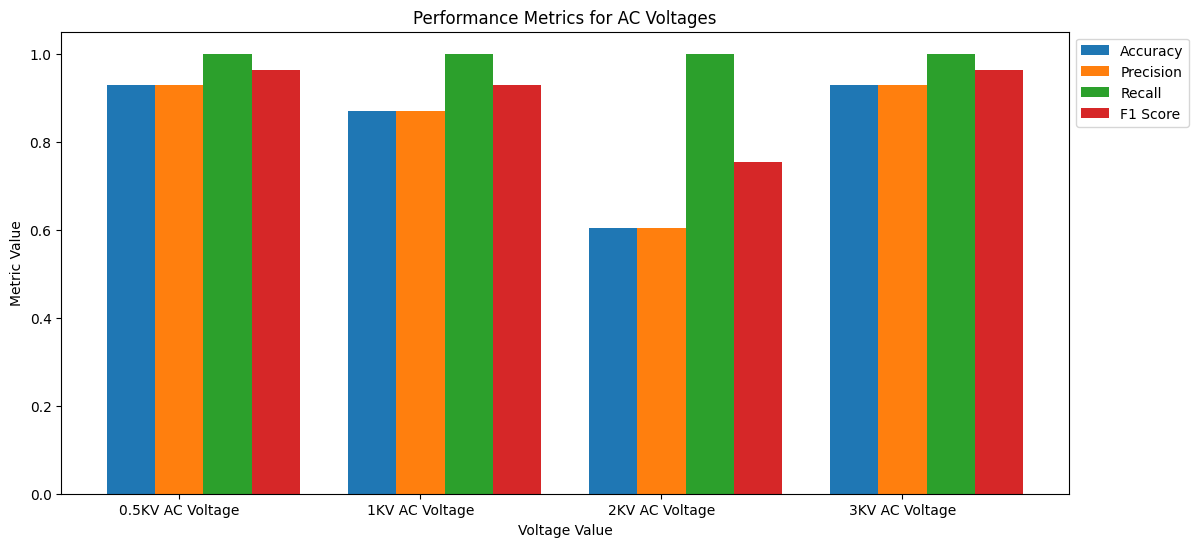

In [41]:
plt.figure(figsize=(13, 6))
x = range(len(ac_data['Testcase']))
plt.bar([i - 0.2 for i in x], ac_data['Accuracy'], width=0.2, label='Accuracy')
plt.bar([i for i in x], ac_data['Precision'], width=0.2, label='Precision')
plt.bar([i + 0.2 for i in x], ac_data['Recall'], width=0.2, label='Recall')
plt.bar([i + 0.4 for i in x], ac_data['F1 Score'], width=0.2, label='F1 Score')
plt.xticks(x, ac_data['Testcase'])
plt.title('Performance Metrics for AC Voltages')
plt.xlabel('Voltage Value')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

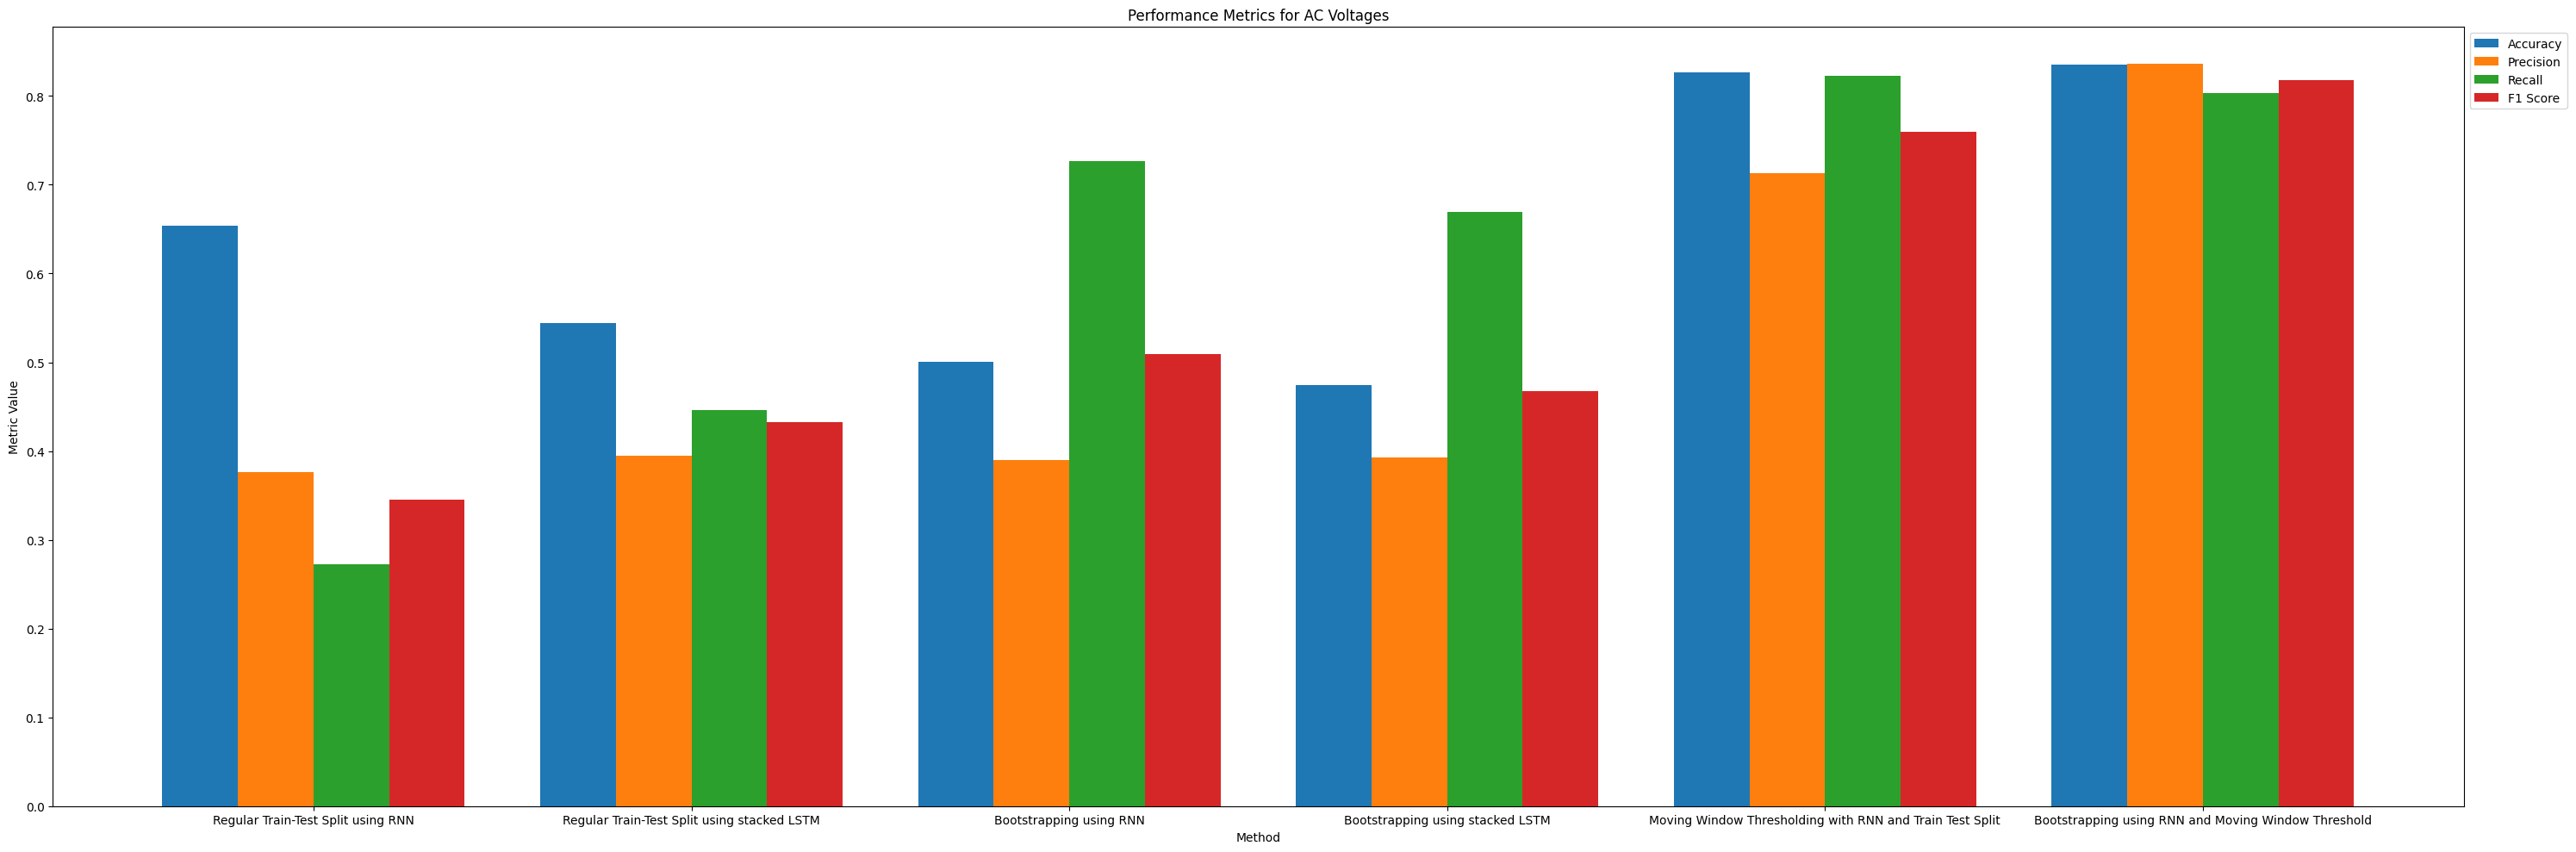

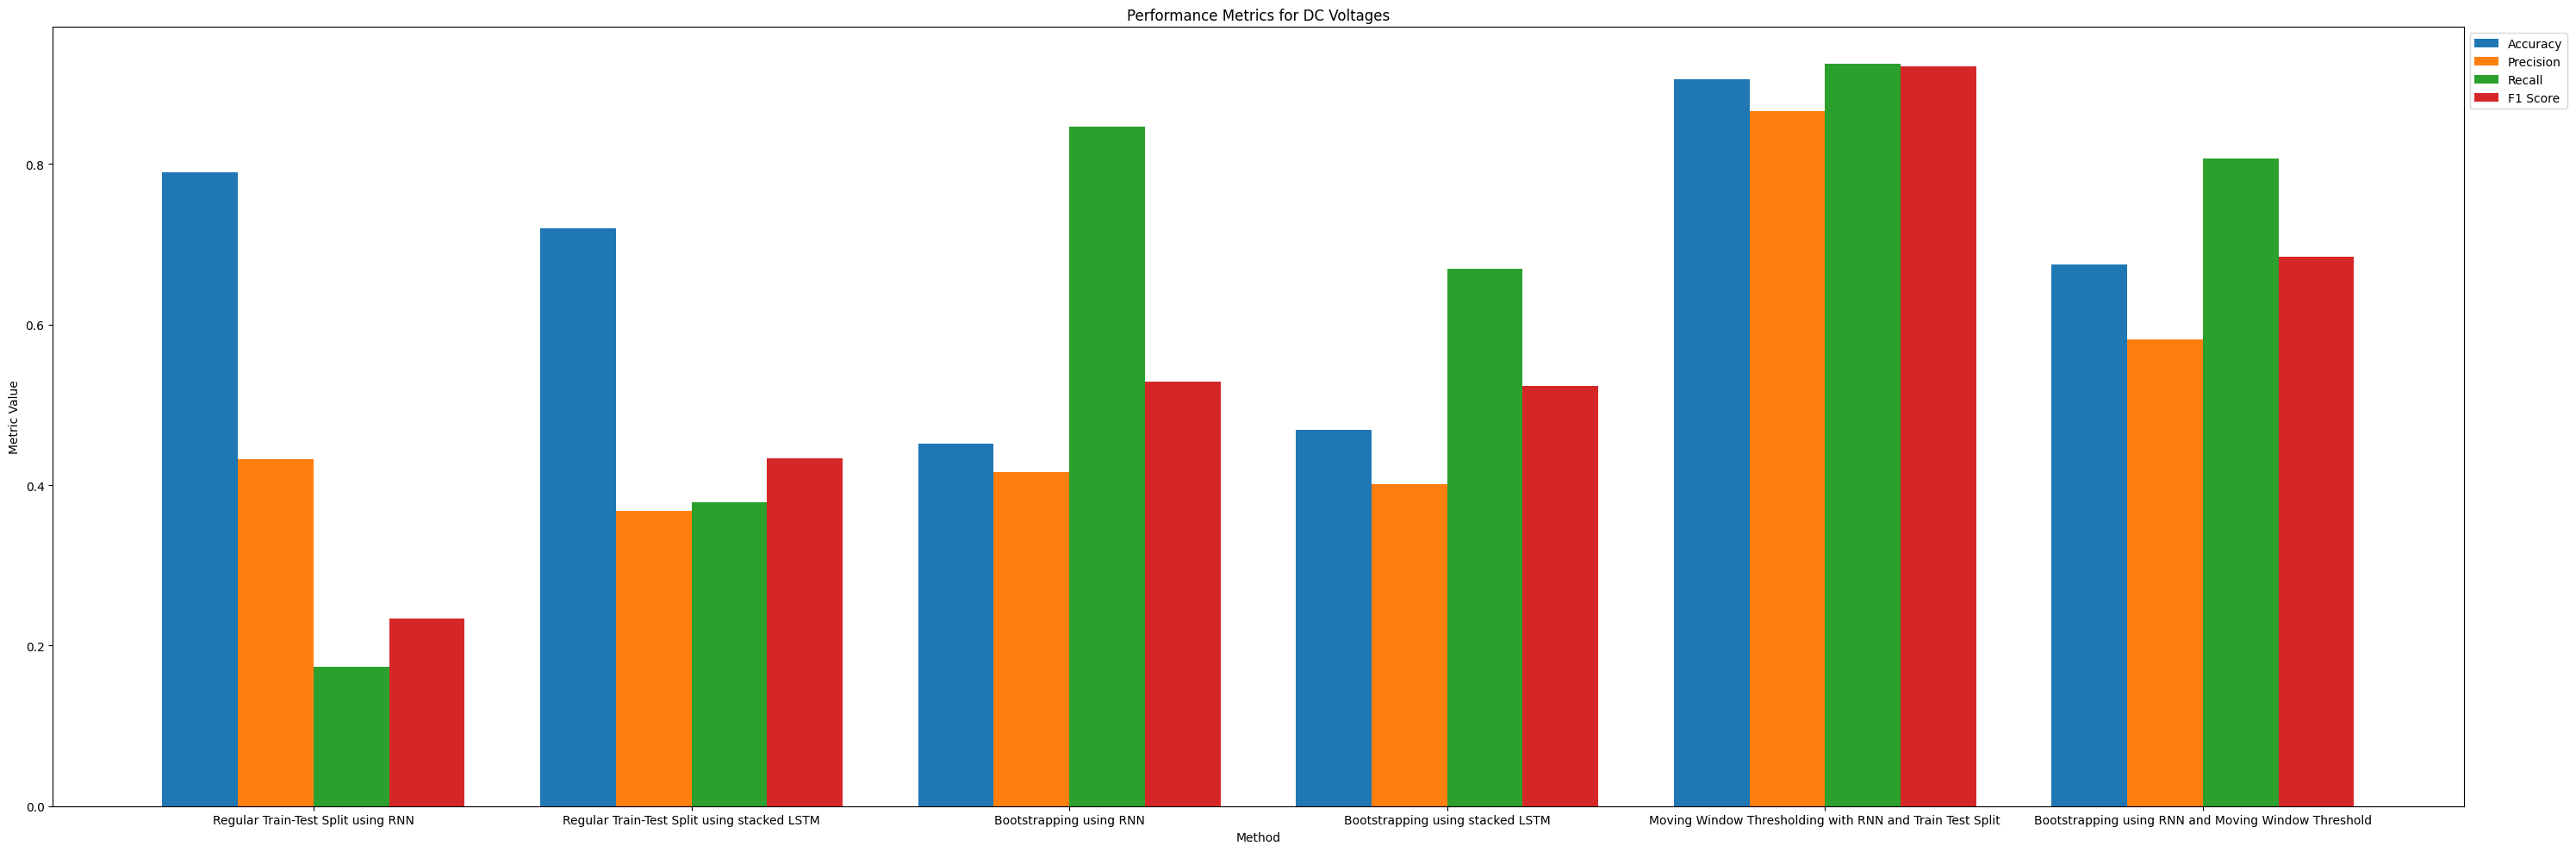

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    "Method": [
        "Regular Train-Test Split using RNN", "Regular Train-Test Split using RNN", 
        "Regular Train-Test Split using stacked LSTM", "Regular Train-Test Split using stacked LSTM",
        "Bootstrapping using RNN", "Bootstrapping using RNN", 
        "Bootstrapping using stacked LSTM", "Bootstrapping using stacked LSTM",
        "Moving Window Thresholding with RNN and Train Test Split", 
        "Moving Window Thresholding with RNN and Train Test Split", 
        "Bootstrapping using RNN and Moving Window Threshold", 
        "Bootstrapping using RNN and Moving Window Threshold"
    ],
    "Voltage Type": [
        "AC", "DC", "AC", "DC", "AC", "DC", "AC", "DC", 
        "AC", "DC", "AC", "DC"
    ],
    "Average Accuracy": [
        0.6535, 0.7898, 0.5442, 0.7198, 0.5005, 0.4519, 0.4746, 0.4682, 
        0.8269, 0.9058, 0.8358, 0.6744
    ],
    "Average Precision": [
        0.3759, 0.4321, 0.3951, 0.3680, 0.3895, 0.4158, 0.3923, 0.4011, 
        0.7131, 0.8653, 0.8359, 0.5815
    ],
    "Average Recall": [
        0.2724, 0.1737, 0.4458, 0.3789, 0.7269, 0.8463, 0.6693, 0.6696, 
        0.8226, 0.9244, 0.8034, 0.8064
    ],
    "Average F1 Score": [
        0.3452, 0.2333, 0.4326, 0.4332, 0.5097, 0.5293, 0.4675, 0.5233, 
        0.7601, 0.9216, 0.8174, 0.6841
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Separate data for AC and DC
ac_data_method = df[df['Voltage Type'] == "AC"]
dc_data_method = df[df['Voltage Type'] == "DC"]

# Plot for AC voltages
plt.figure(figsize=(30, 10))
x = range(len(ac_data_method['Method']))
plt.bar([i - 0.3 for i in x], ac_data_method['Average Accuracy'], width=0.2, label='Accuracy')
plt.bar([i - 0.1 for i in x], ac_data_method['Average Precision'], width=0.2, label='Precision')
plt.bar([i + 0.1 for i in x], ac_data_method['Average Recall'], width=0.2, label='Recall')
plt.bar([i + 0.3 for i in x], ac_data_method['Average F1 Score'], width=0.2, label='F1 Score')
plt.xticks(x, ac_data_method['Method'], rotation=0, ha="center")
plt.title('Performance Metrics for AC Voltages')
plt.xlabel('Method')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot for DC voltages
plt.figure(figsize=(30, 10))
x = range(len(dc_data_method['Method']))
plt.bar([i - 0.3 for i in x], dc_data_method['Average Accuracy'], width=0.2, label='Accuracy')
plt.bar([i - 0.1 for i in x], dc_data_method['Average Precision'], width=0.2, label='Precision')
plt.bar([i + 0.1 for i in x], dc_data_method['Average Recall'], width=0.2, label='Recall')
plt.bar([i + 0.3 for i in x], dc_data_method['Average F1 Score'], width=0.2, label='F1 Score')
plt.xticks(x, dc_data_method['Method'], rotation=0, ha="center")
plt.title('Performance Metrics for DC Voltages')
plt.xlabel('Method')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


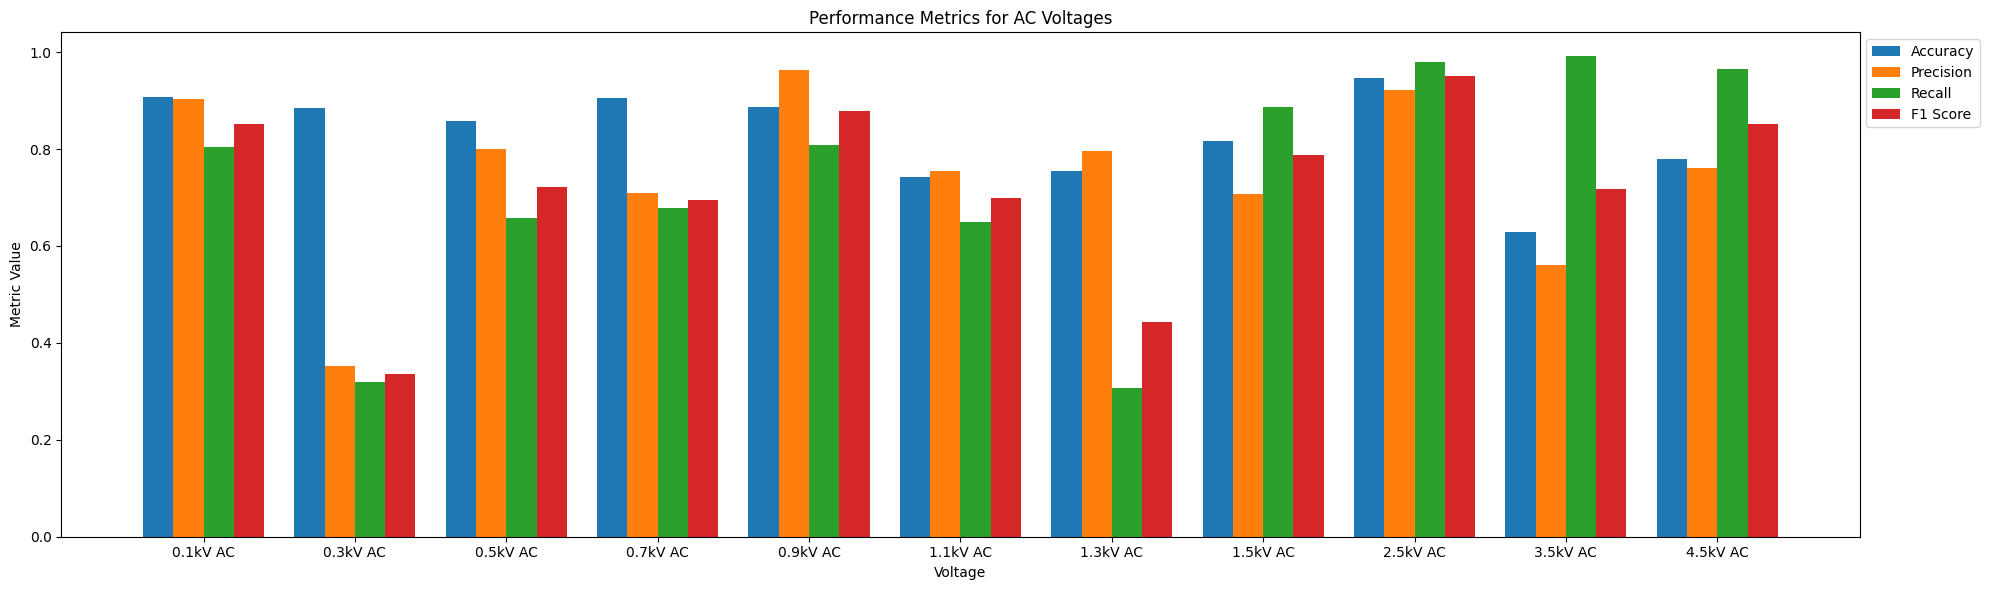

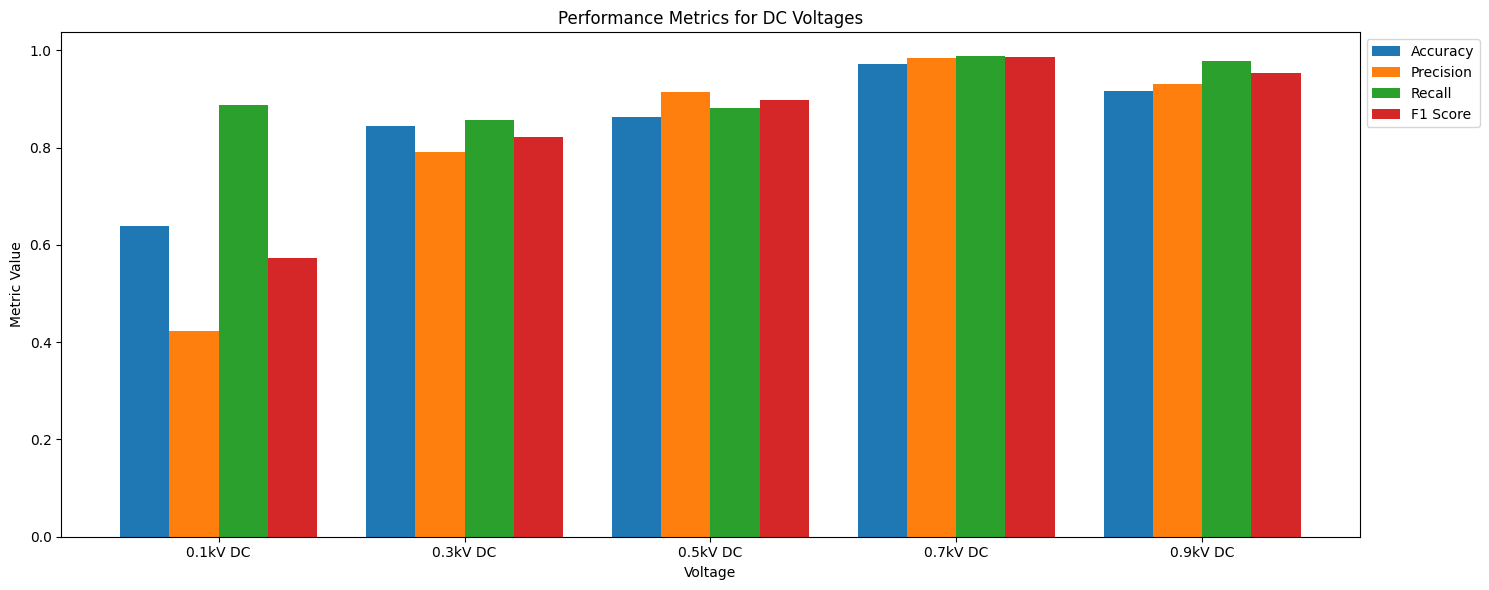

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (Replace this with your actual data)
data = {
    "Voltage": [
        "0.1kV AC", "0.1kV DC", "0.3kV DC", "0.3kV AC", "0.5kV DC", "0.5kV AC", 
        "0.7kV DC", "0.7kV AC", "0.9kV DC", "0.9kV AC", "1.1kV AC", "1.3kV AC", 
        "1.5kV AC", "2.5kV AC", "3.5kV AC", "4.5kV AC"
    ],
    "Accuracy": [
        0.9067, 0.6392, 0.8433, 0.8846, 0.8629, 0.8576, 0.9724, 0.9055, 
        0.9166, 0.8860, 0.7417, 0.7554, 0.8156, 0.9474, 0.6281, 0.7799
    ],
    "Precision": [
        0.9031, 0.4231, 0.7899, 0.3523, 0.9140, 0.7993, 0.9838, 0.7094, 
        0.9301, 0.9633, 0.7542, 0.7966, 0.7071, 0.9224, 0.5613, 0.7601
    ],
    "Recall": [
        0.8050, 0.8882, 0.8561, 0.3196, 0.8822, 0.6580, 0.9874, 0.6792, 
        0.9778, 0.8074, 0.6494, 0.3062, 0.8866, 0.9797, 0.9912, 0.9655
    ],
    "F1 Score": [
        0.8513, 0.5731, 0.8217, 0.3351, 0.8978, 0.7218, 0.9856, 0.6940, 
        0.9534, 0.8785, 0.6979, 0.4424, 0.7868, 0.9502, 0.7168, 0.8506
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Separate AC and DC data
ac_data = df[df['Voltage'].str.contains("AC")]
dc_data = df[df['Voltage'].str.contains("DC")]

# Plot for AC voltages
plt.figure(figsize=(20, 6))
x = range(len(ac_data['Voltage']))
plt.bar([i - 0.3 for i in x], ac_data['Accuracy'], width=0.2, label='Accuracy')
plt.bar([i - 0.1 for i in x], ac_data['Precision'], width=0.2, label='Precision')
plt.bar([i + 0.1 for i in x], ac_data['Recall'], width=0.2, label='Recall')
plt.bar([i + 0.3 for i in x], ac_data['F1 Score'], width=0.2, label='F1 Score')
plt.xticks(x, ac_data['Voltage'], rotation=0, ha="center")
plt.title('Performance Metrics for AC Voltages')
plt.xlabel('Voltage')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot for DC voltages
plt.figure(figsize=(15, 6))
x = range(len(dc_data['Voltage']))
plt.bar([i - 0.3 for i in x], dc_data['Accuracy'], width=0.2, label='Accuracy')
plt.bar([i - 0.1 for i in x], dc_data['Precision'], width=0.2, label='Precision')
plt.bar([i + 0.1 for i in x], dc_data['Recall'], width=0.2, label='Recall')
plt.bar([i + 0.3 for i in x], dc_data['F1 Score'], width=0.2, label='F1 Score')
plt.xticks(x, dc_data['Voltage'], rotation=0, ha="center")
plt.title('Performance Metrics for DC Voltages')
plt.xlabel('Voltage')
plt.ylabel('Metric Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
